# 올림픽 메달 수 예측하기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

## 데이터 불러오기

In [2]:
summer = pd.read_csv("../project/data/summer.csv")
winter = pd.read_csv("../project/data/winter.csv")

In [3]:
summer.tail()

,Year,City,Sport,Discipline,Athlete,Country,Gender,Event,Medal
31160,2012,London,Wrestling,Wrestling Freestyle,"JANIKOWSKI, Damian",POL,Men,Wg 84 KG,Bronze
31161,2012,London,Wrestling,Wrestling Freestyle,"REZAEI, Ghasem Gholamreza",IRI,Men,Wg 96 KG,Gold
31162,2012,London,Wrestling,Wrestling Freestyle,"TOTROV, Rustam",RUS,Men,Wg 96 KG,Silver
31163,2012,London,Wrestling,Wrestling Freestyle,"ALEKSANYAN, Artur",ARM,Men,Wg 96 KG,Bronze
31164,2012,London,Wrestling,Wrestling Freestyle,"LIDBERG, Jimmy",SWE,Men,Wg 96 KG,Bronze


## 데이터 기본 분석
### 데이터 전처리

#### 1994년 이후 데이터로 축소하기
- 여러 국가들의 국정상태에 따라서 참가국형태가 상이한데 비해(분리국가, 통일국가 등) 1994년 올림픽 참가국들이 현재 올림픽 참가국들과 일치함.
   - ex) 구소련, 동독과 서독, 중국과 대만, 체코와 슬로바키아 등
   - https://en.wikipedia.org/wiki/All-time_Olympic_Games_medal_table 

In [4]:
summer = summer[summer.Year >= 1994].reset_index().drop("index", axis = 1)
summer = summer.rename(columns = {"Country":"Code"})
summer.head(1)

,Year,City,Sport,Discipline,Athlete,Code,Gender,Event,Medal
0,1996,Atlanta,Aquatics,Diving,"XIAO, Hailiang",CHN,Men,10M Platform,Bronze


#### Null 값 확인하기

In [5]:
summer.isnull().sum()

Year          0
City          0
Sport         0
Discipline    0
Athlete       0
Code          4
Gender        0
Event         0
Medal         0
dtype: int64

In [6]:
summer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9863 entries, 0 to 9862
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Year        9863 non-null   int64 
 1   City        9863 non-null   object
 2   Sport       9863 non-null   object
 3   Discipline  9863 non-null   object
 4   Athlete     9863 non-null   object
 5   Code        9859 non-null   object
 6   Gender      9863 non-null   object
 7   Event       9863 non-null   object
 8   Medal       9863 non-null   object
dtypes: int64(1), object(8)
memory usage: 693.6+ KB


#### top30로 축소하기
- 30위 범위 밖에 위치한 국가들은 매회마다 저조한 성적을 기록함으로 분석 범위를 30위권으로 좁히기로 하였다.

In [7]:
summer_top30_index = summer.groupby("Code")["Medal"].count().sort_values(ascending = False).head(30).index
summer_top30_index

Index(['USA', 'RUS', 'AUS', 'CHN', 'GER', 'NED', 'ITA', 'GBR', 'KOR', 'FRA',
       'JPN', 'BRA', 'ESP', 'CUB', 'CAN', 'HUN', 'UKR', 'ROU', 'ARG', 'NOR',
       'BLR', 'DEN', 'SWE', 'CRO', 'JAM', 'POL', 'GRE', 'NGR', 'NZL', 'BUL'],
      dtype='object', name='Code')

In [8]:
summer = summer[summer.Code.isin(summer_top30_index)].copy()
summer

,Year,City,Sport,Discipline,Athlete,Code,Gender,Event,Medal
0,1996,Atlanta,Aquatics,Diving,"XIAO, Hailiang",CHN,Men,10M Platform,Bronze
1,1996,Atlanta,Aquatics,Diving,"SAUTIN, Dmitry",RUS,Men,10M Platform,Gold
2,1996,Atlanta,Aquatics,Diving,"HEMPEL, Jan",GER,Men,10M Platform,Silver
3,1996,Atlanta,Aquatics,Diving,"CLARK, Mary Ellen",USA,Women,10M Platform,Bronze
4,1996,Atlanta,Aquatics,Diving,"FU, Mingxia",CHN,Women,10M Platform,Gold
...,...,...,...,...,...,...,...,...,...
9851,2012,London,Wrestling,Wrestling Freestyle,"VLASOV, Roman",RUS,Men,Wg 74 KG,Gold
9855,2012,London,Wrestling,Wrestling Freestyle,"KHUGAEV, Alan",RUS,Men,Wg 84 KG,Gold
9858,2012,London,Wrestling,Wrestling Freestyle,"JANIKOWSKI, Damian",POL,Men,Wg 84 KG,Bronze
9860,2012,London,Wrestling,Wrestling Freestyle,"TOTROV, Rustam",RUS,Men,Wg 96 KG,Silver


In [9]:
summer.isnull().sum()

Year          0
City          0
Sport         0
Discipline    0
Athlete       0
Code          0
Gender        0
Event         0
Medal         0
dtype: int64

#### 개최국 표시하기

In [10]:
host = {"City": ["Athens", "Atlanta", "Beijing", "London", "Sydney"],
             "HostCountry": ["Greece", "United States", "China", "United Kingdom", "Australia"]}
host = pd.DataFrame(data = host)
host

,City,HostCountry
0,Athens,Greece
1,Atlanta,United States
2,Beijing,China
3,London,United Kingdom
4,Sydney,Australia


In [11]:
summer = summer.merge(host, left_on = "City", right_on = "City").copy()
summer

,Year,City,Sport,Discipline,Athlete,Code,Gender,Event,Medal,HostCountry
0,1996,Atlanta,Aquatics,Diving,"XIAO, Hailiang",CHN,Men,10M Platform,Bronze,United States
1,1996,Atlanta,Aquatics,Diving,"SAUTIN, Dmitry",RUS,Men,10M Platform,Gold,United States
2,1996,Atlanta,Aquatics,Diving,"HEMPEL, Jan",GER,Men,10M Platform,Silver,United States
3,1996,Atlanta,Aquatics,Diving,"CLARK, Mary Ellen",USA,Women,10M Platform,Bronze,United States
4,1996,Atlanta,Aquatics,Diving,"FU, Mingxia",CHN,Women,10M Platform,Gold,United States
...,...,...,...,...,...,...,...,...,...,...
8696,2012,London,Wrestling,Wrestling Freestyle,"VLASOV, Roman",RUS,Men,Wg 74 KG,Gold,United Kingdom
8697,2012,London,Wrestling,Wrestling Freestyle,"KHUGAEV, Alan",RUS,Men,Wg 84 KG,Gold,United Kingdom
8698,2012,London,Wrestling,Wrestling Freestyle,"JANIKOWSKI, Damian",POL,Men,Wg 84 KG,Bronze,United Kingdom
8699,2012,London,Wrestling,Wrestling Freestyle,"TOTROV, Rustam",RUS,Men,Wg 96 KG,Silver,United Kingdom


#### 단체스포츠 중복 메달 수 제거하기

In [12]:
summer["Sport"].unique()

array(['Aquatics', 'Archery', 'Athletics', 'Badminton', 'Baseball',
       'Basketball', 'Boxing', 'Canoe / Kayak', 'Cycling', 'Equestrian',
       'Fencing', 'Football', 'Gymnastics', 'Handball', 'Hockey', 'Judo',
       'Modern Pentathlon', 'Rowing', 'Sailing', 'Shooting', 'Softball',
       'Table Tennis', 'Tennis', 'Volleyball', 'Weightlifting',
       'Wrestling', 'Taekwondo', 'Triathlon', 'Canoe'], dtype=object)

In [13]:
summer["Event"].unique()

array(['10M Platform', '3M Springboard', '100M Backstroke',
       '100M Breaststroke', '100M Butterfly', '100M Freestyle',
       '1500M Freestyle', '200M Backstroke', '200M Breaststroke',
       '200M Butterfly', '200M Freestyle', '200M Individual Medley',
       '400M Freestyle', '400M Individual Medley',
       '4X100M Freestyle Relay', '4X100M Medley Relay',
       '4X200M Freestyle Relay', '50M Freestyle', '800M Freestyle',
       'Team', 'Water Polo', 'Individual (Fita Olympic Round - 70M)',
       'Team (Fita Olympic Round - 70M)', '10000M', '10000M Walk', '100M',
       '100M Hurdles', '110M Hurdles', '1500M', '200M', '20KM Walk',
       '3000M Steeplechase', '400M', '400M Hurdles', '4X100M Relay',
       '4X400M Relay', '5000M', '50KM Walk', '800M', 'Decathlon',
       'Discus Throw', 'Hammer Throw', 'Heptathlon', 'High Jump',
       'Javelin Throw', 'Long Jump', 'Marathon', 'Pole Vault', 'Shot Put',
       'Triple Jump', 'Doubles', 'Singles', 'Baseball', 'Basketball',
      

In [14]:
summer = summer.drop(["Athlete"], axis = 1)
summer = summer.drop_duplicates()
summer

,Year,City,Sport,Discipline,Code,Gender,Event,Medal,HostCountry
0,1996,Atlanta,Aquatics,Diving,CHN,Men,10M Platform,Bronze,United States
1,1996,Atlanta,Aquatics,Diving,RUS,Men,10M Platform,Gold,United States
2,1996,Atlanta,Aquatics,Diving,GER,Men,10M Platform,Silver,United States
3,1996,Atlanta,Aquatics,Diving,USA,Women,10M Platform,Bronze,United States
4,1996,Atlanta,Aquatics,Diving,CHN,Women,10M Platform,Gold,United States
...,...,...,...,...,...,...,...,...,...
8696,2012,London,Wrestling,Wrestling Freestyle,RUS,Men,Wg 74 KG,Gold,United Kingdom
8697,2012,London,Wrestling,Wrestling Freestyle,RUS,Men,Wg 84 KG,Gold,United Kingdom
8698,2012,London,Wrestling,Wrestling Freestyle,POL,Men,Wg 84 KG,Bronze,United Kingdom
8699,2012,London,Wrestling,Wrestling Freestyle,RUS,Men,Wg 96 KG,Silver,United Kingdom


### 예상 변수 데이터들 합치기
#### GDP데이터
> https://www.kaggle.com/greeshmagirish/worldbank-data-on-gdp-population-and-military?select=API_NY.GDP.MKTP.CD_DS2_en_csv_v2_559588.csv

In [15]:
gdp = pd.read_csv("../project/data/gdp.csv")
gdp = gdp[["Country Name", "Country Code", "1996", "2000", "2004", "2008", "2012"]]#.set_index(["Country Name","Country Code"])
gdp = gdp.rename(columns = {"Country Name" : "Country", "Country Code" : "Code"})
gdp.head()

,Country,Code,1996,2000,2004,2008,2012
0,Aruba,ABW,1.379961e+09,1.873453e+09,2.228492e+09,2.745251e+09,2.534637e+09
1,Afghanistan,AFG,NaN,NaN,5.226775e+09,1.010922e+10,2.000162e+10
2,Angola,AGO,7.526447e+09,9.129595e+09,2.355205e+10,8.853861e+10,1.280529e+11
3,Albania,ALB,3.199643e+09,3.480355e+09,7.184681e+09,1.288135e+10,1.231978e+10
4,Andorra,AND,1.223945e+09,1.434430e+09,2.935659e+09,4.007353e+09,3.164615e+09


In [16]:
summertop30 = ['USA', 'RUS', 'AUS', 'CHN', 'GER', 'NED', 'ITA', 'GBR', 'KOR', 'FRA',
       'JPN', 'BRA', 'ESP', 'CUB', 'CAN', 'HUN', 'UKR', 'ROU', 'ARG', 'NOR',
       'BLR', 'DEN', 'SWE', 'CRO', 'JAM', 'POL', 'GRE', 'NGR', 'NZL', 'BUL']

In [17]:
"|".join(summertop30)

'USA|RUS|AUS|CHN|GER|NED|ITA|GBR|KOR|FRA|JPN|BRA|ESP|CUB|CAN|HUN|UKR|ROU|ARG|NOR|BLR|DEN|SWE|CRO|JAM|POL|GRE|NGR|NZL|BUL'

In [18]:
gdp = gdp.melt(id_vars = ["Code", "Country"], value_vars = ["1996", "2000", "2004", "2008", "2012"],
          var_name = 'Year', value_name = 'GDP').sort_values(by = ["Code", "Year"]).reset_index(drop = True)
gdp.Year = gdp.Year.astype(int)
gdp.head()

,Code,Country,Year,GDP
0,ABW,Aruba,1996,1.379961e+09
1,ABW,Aruba,2000,1.873453e+09
2,ABW,Aruba,2004,2.228492e+09
3,ABW,Aruba,2008,2.745251e+09
4,ABW,Aruba,2012,2.534637e+09


In [19]:
gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Code     1320 non-null   object 
 1   Country  1320 non-null   object 
 2   Year     1320 non-null   int32  
 3   GDP      1233 non-null   float64
dtypes: float64(1), int32(1), object(2)
memory usage: 36.2+ KB


In [20]:
# summer_gdp = pd.merge(left = summer, right = gdp, how = "left",
#                       left_on = ["Year", "Code"],right_on = ["Year", "Code"]).copy()
# summer_gdp

In [21]:
# summer_gdp.isnull().sum()

In [22]:
# summer_gdp.loc[summer_gdp.GDP.isnull() == True].groupby(["Code", "Year"])["GDP"].count()

In [23]:
gdp.head()

,Code,Country,Year,GDP
0,ABW,Aruba,1996,1.379961e+09
1,ABW,Aruba,2000,1.873453e+09
2,ABW,Aruba,2004,2.228492e+09
3,ABW,Aruba,2008,2.745251e+09
4,ABW,Aruba,2012,2.534637e+09


In [24]:
gdp.loc[gdp.Country == "Nigeria"]

,Code,Country,Year,GDP
860,NGA,Nigeria,1996,5.107582e+10
861,NGA,Nigeria,2000,6.944876e+10
862,NGA,Nigeria,2004,1.363860e+11
863,NGA,Nigeria,2008,3.370355e+11
864,NGA,Nigeria,2012,4.593760e+11


In [25]:
gdp.loc[gdp.Country == "Greece"]

,Code,Country,Year,GDP
435,GRC,Greece,1996,1.458616e+11
436,GRC,Greece,2000,1.301338e+11
437,GRC,Greece,2004,2.405213e+11
438,GRC,Greece,2008,3.544608e+11
439,GRC,Greece,2012,2.456707e+11


In [26]:
gdp.Code = gdp.Code.str.replace("DEU", "GER")
gdp.Code = gdp.Code.str.replace("BGR", "BUL")
gdp.Code = gdp.Code.str.replace("HRV", "CRO")
gdp.Code = gdp.Code.str.replace("DNK", "DEN")
gdp.Code = gdp.Code.str.replace("GRC", "GRE")
gdp.Code = gdp.Code.str.replace("NLD", "NED")
gdp.Code = gdp.Code.str.replace("NGA", "NGR")

In [27]:
summer_gdp = pd.merge(left = summer, right = gdp, how = "left",
                      left_on = ["Year", "Code"],right_on = ["Year", "Code"]).copy()
summer_gdp

,Year,City,Sport,Discipline,Code,Gender,Event,Medal,HostCountry,Country,GDP
0,1996,Atlanta,Aquatics,Diving,CHN,Men,10M Platform,Bronze,United States,China,8.637467e+11
1,1996,Atlanta,Aquatics,Diving,RUS,Men,10M Platform,Gold,United States,Russian Federation,3.917249e+11
2,1996,Atlanta,Aquatics,Diving,GER,Men,10M Platform,Silver,United States,Germany,2.503665e+12
3,1996,Atlanta,Aquatics,Diving,USA,Women,10M Platform,Bronze,United States,United States,8.073122e+12
4,1996,Atlanta,Aquatics,Diving,CHN,Women,10M Platform,Gold,United States,China,8.637467e+11
...,...,...,...,...,...,...,...,...,...,...,...
3791,2012,London,Wrestling,Wrestling Freestyle,RUS,Men,Wg 74 KG,Gold,United Kingdom,Russian Federation,2.210257e+12
3792,2012,London,Wrestling,Wrestling Freestyle,RUS,Men,Wg 84 KG,Gold,United Kingdom,Russian Federation,2.210257e+12
3793,2012,London,Wrestling,Wrestling Freestyle,POL,Men,Wg 84 KG,Bronze,United Kingdom,Poland,5.003608e+11
3794,2012,London,Wrestling,Wrestling Freestyle,RUS,Men,Wg 96 KG,Silver,United Kingdom,Russian Federation,2.210257e+12


In [28]:
summer_gdp.isnull().sum()

Year           0
City           0
Sport          0
Discipline     0
Code           0
Gender         0
Event          0
Medal          0
HostCountry    0
Country        0
GDP            0
dtype: int64

#### 인구데이터 합치기
> https://datahub.io/JohnSnowLabs/population-figures-by-country

In [29]:
pop = pd.read_csv("../project/data/population-figures-by-country-csv_csv.csv")
pop = pop[["Country", "Country_Code", "Year_1996", "Year_2000", "Year_2004", "Year_2008", "Year_2012"]]
pop.columns = ["Country", "Code", "1996", "2000", "2004", "2008", "2012"]
pop

,Country,Code,1996,2000,2004,2008,2012
0,Aruba,ABW,83200.0,90853,98737.00,101353.0,102577.00
1,Afghanistan,AFG,17822884.0,20093756,24118979.00,27294031.0,30696958.00
2,Angola,AGO,14682284.0,16440924,18865716.00,21759420.0,25096150.00
3,Albania,ALB,3168033.0,3089027,3026939.00,2947314.0,2900401.00
4,Andorra,AND,64360.0,65390,76244.00,83861.0,82431.00
...,...,...,...,...,...,...,...
258,Kosovo,XKX,2059000.0,1700000,1704622.00,1747383.0,1805200.00
259,"Yemen, Rep.",YEM,15889449.0,17874725,20017068.00,22356391.0,24909969.00
260,South Africa,ZAF,42210216.0,44896856,47001700.99,49557573.3,52506515.08
261,Zambia,ZMB,9394304.0,10531221,11731746.00,13082517.0,14699937.00


In [30]:
pop.loc[pop.Country == "Croatia"]

,Country,Code,1996,2000,2004,2008,2012
97,Croatia,HRV,4494000.0,4426000,4439000.0,4434508.0,4267558.0


In [31]:
pop_melt = pop.melt(id_vars = ["Code","Country"], value_vars = ["1996", "2000", "2004", "2008", "2012"],
          var_name = 'Year', value_name = 'Population').sort_values(by = ["Code", "Year"]).reset_index(drop = True)
pop_melt.Year = pop_melt.Year.astype(int)
pop_melt.head()

,Code,Country,Year,Population
0,ABW,Aruba,1996,83200.0
1,ABW,Aruba,2000,90853.0
2,ABW,Aruba,2004,98737.0
3,ABW,Aruba,2008,101353.0
4,ABW,Aruba,2012,102577.0


In [32]:
pop_melt.Code = pop_melt.Code.str.replace("DEU", "GER")
pop_melt.Code = pop_melt.Code.str.replace("BGR", "BUL")
pop_melt.Code = pop_melt.Code.str.replace("HRV", "CRO")
pop_melt.Code = pop_melt.Code.str.replace("DNK", "DEN")
pop_melt.Code = pop_melt.Code.str.replace("GRC", "GRE")
pop_melt.Code = pop_melt.Code.str.replace("NLD", "NED")
pop_melt.Code = pop_melt.Code.str.replace("NGA", "NGR")

In [43]:
summer_gdp_pop = pd.merge(left = summer_gdp, right = pop_melt, how = "left", left_on = ["Year", "Code", "Country"], 
                          right_on = ["Year", "Code" ,"Country"]).copy()
summer_gdp_pop

,Year,City,Sport,Discipline,Code,Gender,Event,Medal,HostCountry,Country,GDP,Population
0,1996,Atlanta,Aquatics,Diving,CHN,Men,10M Platform,Bronze,United States,China,8.637467e+11,1.217550e+09
1,1996,Atlanta,Aquatics,Diving,RUS,Men,10M Platform,Gold,United States,Russian Federation,3.917249e+11,1.481600e+08
2,1996,Atlanta,Aquatics,Diving,GER,Men,10M Platform,Silver,United States,Germany,2.503665e+12,8.191483e+07
3,1996,Atlanta,Aquatics,Diving,USA,Women,10M Platform,Bronze,United States,United States,8.073122e+12,2.693940e+08
4,1996,Atlanta,Aquatics,Diving,CHN,Women,10M Platform,Gold,United States,China,8.637467e+11,1.217550e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
3791,2012,London,Wrestling,Wrestling Freestyle,RUS,Men,Wg 74 KG,Gold,United Kingdom,Russian Federation,2.210257e+12,1.432017e+08
3792,2012,London,Wrestling,Wrestling Freestyle,RUS,Men,Wg 84 KG,Gold,United Kingdom,Russian Federation,2.210257e+12,1.432017e+08
3793,2012,London,Wrestling,Wrestling Freestyle,POL,Men,Wg 84 KG,Bronze,United Kingdom,Poland,5.003608e+11,3.806316e+07
3794,2012,London,Wrestling,Wrestling Freestyle,RUS,Men,Wg 96 KG,Silver,United Kingdom,Russian Federation,2.210257e+12,1.432017e+08


In [44]:
summer_gdp_pop.isnull().sum()

Year           0
City           0
Sport          0
Discipline     0
Code           0
Gender         0
Event          0
Medal          0
HostCountry    0
Country        0
GDP            0
Population     0
dtype: int64

In [45]:
countries[countries.isin(countrylist) == False]

NameError: name 'countries' is not defined

#### 기온데이터 합치기
> https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data

In [46]:
countries = summer_gdp_pop["Country"].unique()
countries
# countries.str.replace(", ", "|")

array(['China', 'Russian Federation', 'Germany', 'United States',
       'Canada', 'Cuba', 'Australia', 'Brazil', 'United Kingdom', 'Italy',
       'Hungary', 'New Zealand', 'Netherlands', 'Sweden', 'Japan',
       'Spain', 'Croatia', 'Korea, Rep.', 'Ukraine', 'Poland', 'Jamaica',
       'France', 'Romania', 'Nigeria', 'Norway', 'Belarus', 'Bulgaria',
       'Greece', 'Denmark', 'Argentina'], dtype=object)

In [47]:
type(countries)

numpy.ndarray

In [48]:
countries = pd.Series(countries)
type(countries)

pandas.core.series.Series

In [49]:
temp2 = pd.read_csv("../project/data/GlobalLandTemperaturesByCountry.csv")
temp2 = temp2.loc[(temp2.dt > "1996-06-01") & (temp2.dt < "2012-10-01")].copy()
temp2 = temp2.loc[temp2.dt.str.contains("1996|2000|2004|2008|2012")]
temp2 = temp2.loc[temp2.dt.str.contains("-07|-08|-09")]
temp2.Country = temp2.Country.str.replace("South Korea", "Korea, Rep.")
temp2.Country = temp2.Country.str.replace("Russia", "Russian Federation")
temp2 = temp2.loc[temp2.Country.isin(countries)].drop(columns = "AverageTemperatureUncertainty", axis = 1)
temp2.columns = ["HostMonth", "CountryTemp", "Country"]
temp2.HostMonth = temp2.HostMonth.str.replace("-01", "")
temp2

,HostMonth,CountryTemp,Country
27160,1996-07,7.544,Argentina
27161,1996-08,11.684,Argentina
27162,1996-09,12.602,Argentina
27208,2000-07,6.306,Argentina
27209,2000-08,9.887,Argentina
...,...,...,...
557759,2008-08,20.543,United States
557760,2008-09,16.567,United States
557806,2012-07,23.008,United States
557807,2012-08,21.422,United States


In [50]:
temp2.Country.unique()

array(['Argentina', 'Australia', 'Belarus', 'Brazil', 'Bulgaria',
       'Canada', 'China', 'Croatia', 'Cuba', 'Denmark', 'France',
       'Germany', 'Greece', 'Hungary', 'Italy', 'Jamaica', 'Japan',
       'Netherlands', 'New Zealand', 'Nigeria', 'Norway', 'Poland',
       'Romania', 'Russian Federation', 'Korea, Rep.', 'Spain', 'Sweden',
       'Ukraine', 'United Kingdom', 'United States'], dtype=object)

In [51]:
temp3 = pd.read_csv("../project/data/GlobalLandTemperaturesByCity.csv")
temp3 = temp3.loc[(temp3.dt > "1996-06-01") & (temp3.dt < "2012-10-01")].copy()
temp3 = temp3.loc[temp3.dt.str.contains("1996|2000|2004|2008|2012")]
temp3 = temp3.loc[temp3.dt.str.contains("-07|-08|-09")]
temp3.Country = temp3.Country.str.replace("South Korea", "Korea, Rep.")
temp3.Country = temp3.Country.str.replace("Russia", "Russian Federation")
temp3 = temp3.loc[temp3.Country.isin(countries)].drop(columns = "AverageTemperatureUncertainty", axis = 1)
temp3.columns = ["HostMonth", "HostCityTemp", "City", "HostCountry", "Latitude", "Longitude"]
temp3.HostMonth = temp3.HostMonth.str.replace("-01", "")
temp3

,HostMonth,HostCityTemp,City,HostCountry,Latitude,Longitude
3032,1996-07,15.684,Århus,Denmark,57.05N,10.33E
3033,1996-08,18.492,Århus,Denmark,57.05N,10.33E
3034,1996-09,12.039,Århus,Denmark,57.05N,10.33E
3080,2000-07,16.244,Århus,Denmark,57.05N,10.33E
3081,2000-08,15.917,Århus,Denmark,57.05N,10.33E
...,...,...,...,...,...,...
8599150,2008-08,17.597,Zwolle,Netherlands,52.24N,5.26E
8599151,2008-09,13.838,Zwolle,Netherlands,52.24N,5.26E
8599197,2012-07,17.329,Zwolle,Netherlands,52.24N,5.26E
8599198,2012-08,18.588,Zwolle,Netherlands,52.24N,5.26E


In [52]:
temp3.loc[temp3.City.str.contains("Beijing")]

,HostMonth,HostCityTemp,City,HostCountry,Latitude,Longitude


In [53]:
temp3.loc[temp3.HostCountry == "China"]["City"].unique()

array(['Ürümqi', 'Acheng', 'Aksu', 'Altay', 'Anbu', 'Anda', 'Ankang',
       'Anqing', 'Anqiu', 'Anshan', 'Anshun', 'Anyang', 'Badaojiang',
       'Baicheng', 'Baiyin', 'Bantou', 'Baoding', 'Baoji', 'Baoshan',
       'Beian', 'Beibei', 'Beihai', 'Beipiao', 'Bengbu', 'Benxi',
       'Binzhou', 'Boshan', 'Bozhou', 'Buhe', 'Cangzhou', 'Changchun',
       'Changde', 'Changji', 'Changzhou', 'Chaohu', 'Chaoyang',
       'Chaozhou', 'Chengde', 'Chengdu', 'Chenghai', 'Chenzhou',
       'Chifeng', 'Chizhou', 'Chongqing', 'Chuncheng', 'Chuzhou', 'Daan',
       'Dali', 'Dalian', 'Daliang', 'Dandong', 'Danshui', 'Datong',
       'Dawukou', 'Daxian', 'Dehui', 'Deyang', 'Dezhou', 'Didao',
       'Dingzhou', 'Donghai', 'Dongli', 'Dongling', 'Dongtai', 'Dongying',
       'Dunhua', 'Encheng', 'Ezhou', 'Fengcheng', 'Foshan', 'Fuling',
       'Fushun', 'Fuxin', 'Fuyang', 'Fuyu', 'Fuzhou', 'Ganzhou', 'Gaomi',
       'Gaozhou', 'Gejiu', 'Gongzhuling', 'Guangshui', 'Guangyuan',
       'Guangzhou', 'Guilin',

In [54]:
citytemp = temp3.loc[temp3.City.str.contains("Atlanta|Athens|Sydney|Peking|London")].copy()
citytemp.City.unique()

array(['Athens', 'Atlanta', 'London', 'Peking', 'Sydney'], dtype=object)

In [55]:
summer_gdp_pop.City.unique()

array(['Atlanta', 'Sydney', 'Athens', 'Beijing', 'London'], dtype=object)

In [56]:
citytemp.City = citytemp.City.str.replace("Peking", "Beijing")
citytemp

,HostMonth,HostCityTemp,City,HostCountry,Latitude,Longitude
463916,1996-07,26.017,Athens,Greece,37.78N,24.41E
463917,1996-08,26.045,Athens,Greece,37.78N,24.41E
463918,1996-09,22.608,Athens,Greece,37.78N,24.41E
463964,2000-07,27.716,Athens,Greece,37.78N,24.41E
463965,2000-08,26.578,Athens,Greece,37.78N,24.41E
...,...,...,...,...,...,...
7296165,2008-08,13.637,Sydney,Australia,34.56S,151.78E
7296166,2008-09,16.340,Sydney,Australia,34.56S,151.78E
7296212,2012-07,14.740,Sydney,Australia,34.56S,151.78E
7296213,2012-08,14.892,Sydney,Australia,34.56S,151.78E


In [57]:
hostcitytemp = citytemp.loc[((citytemp.City == "Athens") & (citytemp.HostMonth == "2004-08")) |
             ((citytemp.City == "Beijing") & (citytemp.HostMonth == "2008-08")) |
            ((citytemp.City == "Sydney") & (citytemp.HostMonth == "2000-09")) |
            ((citytemp.City == "Atlanta") & (citytemp.HostMonth == "1996-07")) |
            ((citytemp.City == "London") & (citytemp.HostMonth == "2012-07") & (citytemp.HostCountry == "United Kingdom"))]
hostcitytemp = hostcitytemp.reset_index(drop = True)
hostcitytemp.sort_values(by = "HostMonth")

,HostMonth,HostCityTemp,City,HostCountry,Latitude,Longitude
1,1996-07,24.538,Atlanta,United States,34.56N,83.68W
4,2000-09,16.932,Sydney,Australia,34.56S,151.78E
0,2004-08,26.556,Athens,Greece,37.78N,24.41E
3,2008-08,25.809,Beijing,China,39.38N,116.53E
2,2012-07,16.487,London,United Kingdom,52.24N,0.00W


In [58]:
summer_gdp_pop.loc[summer_gdp_pop.City == "Atlanta", "HostMonth"] = "1996-07"
summer_gdp_pop.loc[summer_gdp_pop.City == "Sydney", "HostMonth"] = "2000-09"
summer_gdp_pop.loc[summer_gdp_pop.City == "Athens", "HostMonth"] = "2004-08"
summer_gdp_pop.loc[summer_gdp_pop.City == "Beijing", "HostMonth"] = "2008-08"
summer_gdp_pop.loc[summer_gdp_pop.City == "London", "HostMonth"] = "2012-07"

In [59]:
summeroly = summer_gdp_pop.merge(hostcitytemp, left_on = ["City", "HostMonth", "HostCountry"],
                                  right_on = ["City", "HostMonth", "HostCountry"]).copy()

In [60]:
summeroly = summeroly.merge(temp2, left_on = ["HostMonth", "Country"], right_on = ["HostMonth", "Country"]).copy()
summeroly

,Year,City,Sport,Discipline,Code,Gender,Event,Medal,HostCountry,Country,GDP,Population,HostMonth,HostCityTemp,Latitude,Longitude,CountryTemp
0,1996,Atlanta,Aquatics,Diving,CHN,Men,10M Platform,Bronze,United States,China,8.637467e+11,1.217550e+09,1996-07,24.538,34.56N,83.68W,19.589
1,1996,Atlanta,Aquatics,Diving,CHN,Women,10M Platform,Gold,United States,China,8.637467e+11,1.217550e+09,1996-07,24.538,34.56N,83.68W,19.589
2,1996,Atlanta,Aquatics,Diving,CHN,Men,3M Springboard,Gold,United States,China,8.637467e+11,1.217550e+09,1996-07,24.538,34.56N,83.68W,19.589
3,1996,Atlanta,Aquatics,Diving,CHN,Men,3M Springboard,Silver,United States,China,8.637467e+11,1.217550e+09,1996-07,24.538,34.56N,83.68W,19.589
4,1996,Atlanta,Aquatics,Diving,CHN,Women,3M Springboard,Gold,United States,China,8.637467e+11,1.217550e+09,1996-07,24.538,34.56N,83.68W,19.589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3791,2012,London,Sailing,Sailing,ARG,Men,470,Bronze,United Kingdom,Argentina,5.459824e+11,4.209674e+07,2012-07,16.487,52.24N,0.00W,6.980
3792,2012,London,Taekwondo,Taekwondo,ARG,Men,68 - 80 KG,Gold,United Kingdom,Argentina,5.459824e+11,4.209674e+07,2012-07,16.487,52.24N,0.00W,6.980
3793,2012,London,Tennis,Tennis,ARG,Men,Singles,Bronze,United Kingdom,Argentina,5.459824e+11,4.209674e+07,2012-07,16.487,52.24N,0.00W,6.980
3794,2012,London,Judo,Judo,GRE,Men,81 - 90KG,Bronze,United Kingdom,Greece,2.456707e+11,1.104501e+07,2012-07,16.487,52.24N,0.00W,27.565


In [61]:
summeroly.isnull().sum()

Year            0
City            0
Sport           0
Discipline      0
Code            0
Gender          0
Event           0
Medal           0
HostCountry     0
Country         0
GDP             0
Population      0
HostMonth       0
HostCityTemp    0
Latitude        0
Longitude       0
CountryTemp     0
dtype: int64

In [62]:
len(summeroly.Country.unique())

30

In [63]:
summeroly["TempDiff"] = summeroly.HostCityTemp - summeroly.CountryTemp

In [64]:
summeroly.sample()

,Year,City,Sport,Discipline,Code,Gender,Event,Medal,HostCountry,Country,GDP,Population,HostMonth,HostCityTemp,Latitude,Longitude,CountryTemp,TempDiff
1919,2004,Athens,Judo,Judo,USA,Men,66 - 73KG (Lightweight),Bronze,Greece,United States,1.221373e+13,292805298.0,2004-08,26.556,37.78N,24.41E,20.175,6.381


#### 개최국 메달수 증감율

In [65]:
medals = summeroly.loc[summeroly.Year == 1996].groupby("Country")["Medal"].count().sort_values(ascending = False).reset_index()
medals = medals.rename(columns = {"Medal" : "Atlanta"})
medals

,Country,Atlanta
0,United States,104
1,Germany,66
2,Russian Federation,63
3,China,50
4,Australia,42
5,France,37
6,Italy,35
7,"Korea, Rep.",28
8,Cuba,25
9,Ukraine,23


In [66]:
sydney = summeroly.loc[summeroly.Year == 2000].groupby("Country")["Medal"].count().sort_values(ascending = False).reset_index()
sydney = sydney.rename(columns = {"Medal" : "Sydney"})
sydney

,Country,Sydney
0,United States,94
1,Russian Federation,89
2,Australia,58
3,China,58
4,Germany,56
5,France,38
6,Italy,34
7,United Kingdom,30
8,Cuba,29
9,"Korea, Rep.",28


In [67]:
Athens = summeroly.loc[summeroly.Year == 2004].groupby("Country")["Medal"].count().sort_values(ascending = False).reset_index()
Athens = Athens.rename(columns = {"Medal" : "Athens"})
Athens

,Country,Athens
0,United States,105
1,Russian Federation,92
2,China,63
3,Germany,50
4,Australia,49
5,Japan,37
6,France,33
7,United Kingdom,32
8,Italy,32
9,"Korea, Rep.",30


In [68]:
beijing = summeroly.loc[summeroly.Year == 2008].groupby("Country")["Medal"].count().sort_values(ascending = False).reset_index()
beijing = beijing.rename(columns = {"Medal" : "Beijing"})
beijing

,Country,Beijing
0,United States,111
1,China,100
2,Russian Federation,72
3,United Kingdom,48
4,Australia,47
5,Germany,42
6,France,41
7,"Korea, Rep.",32
8,Italy,27
9,Ukraine,27


In [69]:
london = summeroly.loc[summeroly.Year == 2012].groupby("Country")["Medal"].count().sort_values(ascending = False).reset_index()
london = london.rename(columns = {"Medal" : "London"})
london

,Country,London
0,United States,104
1,China,91
2,Russian Federation,72
3,United Kingdom,68
4,Germany,45
5,Japan,38
6,Australia,35
7,France,35
8,"Korea, Rep.",30
9,Italy,28


In [70]:
all_medals = pd.merge(medals, sydney, left_on = "Country", right_on = "Country")
all_medals = pd.merge(all_medals, Athens, left_on = "Country", right_on = "Country")
all_medals = pd.merge(all_medals, beijing, left_on = "Country", right_on = "Country")
all_medals = pd.merge(all_medals, london, left_on = "Country", right_on = "Country", how = "left")

all_medals.London = all_medals.London.fillna(0).astype(int)
all_medals
# all_medals.Sum = all_medals.Atlanta + all_medals.Sydney

,Country,Atlanta,Sydney,Athens,Beijing,London
0,United States,104,94,105,111,104
1,Germany,66,56,50,42,45
2,Russian Federation,63,89,92,72,72
3,China,50,58,63,100,91
4,Australia,42,58,49,47,35
5,France,37,38,33,41,35
6,Italy,35,34,32,27,28
7,"Korea, Rep.",28,28,30,32,30
8,Cuba,25,29,27,24,15
9,Ukraine,23,23,23,27,19


In [71]:
all_medals["Sum"] = all_medals.Atlanta + all_medals.Sydney + all_medals.Athens + all_medals.Beijing + all_medals.London
all_medals.style.background_gradient(cmap = "BuGn")

,Country,Atlanta,Sydney,Athens,Beijing,London,Sum
0,United States,104,94,105,111,104,518
1,Germany,66,56,50,42,45,259
2,Russian Federation,63,89,92,72,72,388
3,China,50,58,63,100,91,362
4,Australia,42,58,49,47,35,231
5,France,37,38,33,41,35,184
6,Italy,35,34,32,27,28,156
7,"Korea, Rep.",28,28,30,32,30,148
8,Cuba,25,29,27,24,15,120
9,Ukraine,23,23,23,27,19,115


In [72]:
import matplotlib.pyplot as plt
import matplotlib

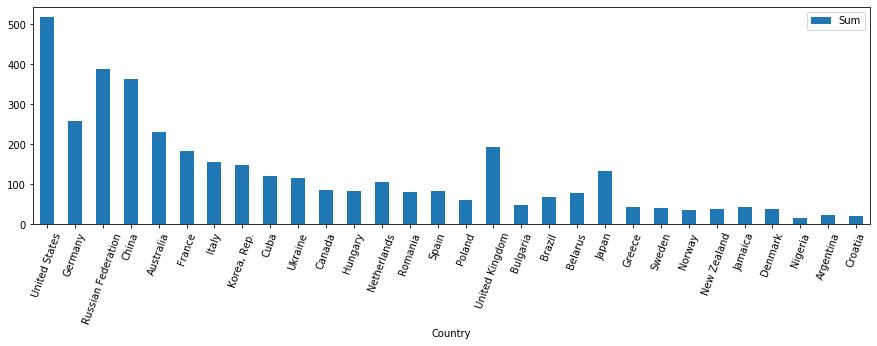

In [73]:
# sns.set_style("whitegrid")
# plt.figure(figsize = (20, 4))
# barplot = plt.bar(data = all_medals, x = "Country", height = "Sum", align = "edge")

all_medals.plot.bar(x = "Country", y = "Sum", figsize = (15, 4), rot = 70)

In [74]:
plt.rc("font", family = "Malgun Gothic")
plt.rc("axes", unicode_minus = False)

각 나라별 메달 현황 그래프그리기

#### 개최년도 1, 0으로 표시하기

In [75]:
summeroly["1996"] = pd.Series()
summeroly["2000"] = pd.Series()
summeroly["2004"] = pd.Series()
summeroly["2008"] = pd.Series()
summeroly["2012"] = pd.Series()

for x in range(3796):
    if summeroly["Year"][x] == 1996:
        summeroly["1996"][x] = 1
    elif summeroly["Year"][x] == 2000:
        summeroly["2000"][x] = 1
    elif summeroly["Year"][x] == 2004:
        summeroly["2004"][x] = 1
    elif summeroly["Year"][x] == 2008:
        summeroly["2008"][x] = 1
    elif summeroly["Year"][x] == 2012:
        summeroly["2012"][x] = 1
    else:
        fillna(0)
        

C:\Users\HJ\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
C:\Users\HJ\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
C:\Users\HJ\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\HJ\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future ve

In [76]:
def host_year(x):
    if summeroly["Year"][x] == 1996 : 
        summeroly["1996"][x] = 1
    else:
        summeroly["1996"][x] = 0

In [77]:
summeroly["Year"][1000]

2000

In [78]:
if summeroly["Year"][0] == 1996 : 
        summeroly["1996"] = 1

In [79]:
summeroly

,Year,City,Sport,Discipline,Code,Gender,Event,Medal,HostCountry,Country,...,HostCityTemp,Latitude,Longitude,CountryTemp,TempDiff,1996,2000,2004,2008,2012
0,1996,Atlanta,Aquatics,Diving,CHN,Men,10M Platform,Bronze,United States,China,...,24.538,34.56N,83.68W,19.589,4.949,1,NaN,NaN,NaN,NaN
1,1996,Atlanta,Aquatics,Diving,CHN,Women,10M Platform,Gold,United States,China,...,24.538,34.56N,83.68W,19.589,4.949,1,NaN,NaN,NaN,NaN
2,1996,Atlanta,Aquatics,Diving,CHN,Men,3M Springboard,Gold,United States,China,...,24.538,34.56N,83.68W,19.589,4.949,1,NaN,NaN,NaN,NaN
3,1996,Atlanta,Aquatics,Diving,CHN,Men,3M Springboard,Silver,United States,China,...,24.538,34.56N,83.68W,19.589,4.949,1,NaN,NaN,NaN,NaN
4,1996,Atlanta,Aquatics,Diving,CHN,Women,3M Springboard,Gold,United States,China,...,24.538,34.56N,83.68W,19.589,4.949,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3791,2012,London,Sailing,Sailing,ARG,Men,470,Bronze,United Kingdom,Argentina,...,16.487,52.24N,0.00W,6.980,9.507,1,NaN,NaN,NaN,1.0
3792,2012,London,Taekwondo,Taekwondo,ARG,Men,68 - 80 KG,Gold,United Kingdom,Argentina,...,16.487,52.24N,0.00W,6.980,9.507,1,NaN,NaN,NaN,1.0
3793,2012,London,Tennis,Tennis,ARG,Men,Singles,Bronze,United Kingdom,Argentina,...,16.487,52.24N,0.00W,6.980,9.507,1,NaN,NaN,NaN,1.0
3794,2012,London,Judo,Judo,GRE,Men,81 - 90KG,Bronze,United Kingdom,Greece,...,16.487,52.24N,0.00W,27.565,-11.078,1,NaN,NaN,NaN,1.0


In [80]:
summeroly[["1996", "2000", "2004", "2008", "2012"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3796 entries, 0 to 3795
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1996    3796 non-null   int64  
 1   2000    768 non-null    float64
 2   2004    771 non-null    float64
 3   2008    777 non-null    float64
 4   2012    764 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 337.9 KB


In [81]:
summeroly[["1996", "2000", "2004", "2008", "2012"]]= summeroly[["1996", "2000", "2004", "2008", "2012"]].fillna(0).astype(int)

In [82]:
summeroly.pivot_table(index = ["Country", "City", "Year"], columns = ["Medal"], aggfunc = "sum")

1996                2000                2004  \
Medal                      Bronze  Gold Silver Bronze  Gold Silver Bronze   
Country       City    Year                                                  
Argentina     Athens  2004    4.0   2.0    NaN    0.0   0.0    NaN    4.0   
              Atlanta 1996    1.0   NaN    2.0    0.0   NaN    0.0    0.0   
              Beijing 2008    4.0   2.0    NaN    0.0   0.0    NaN    0.0   
              London  2012    2.0   1.0    1.0    0.0   0.0    0.0    0.0   
              Sydney  2000    2.0   NaN    2.0    2.0   NaN    2.0    0.0   
...                           ...   ...    ...    ...   ...    ...    ...   
United States Athens  2004   29.0  37.0   39.0    0.0   0.0    0.0   29.0   
              Atlanta 1996   26.0  44.0   34.0    0.0   0.0    0.0    0.0   
              Beijing 2008   36.0  37.0   38.0    0.0   0.0    0.0    0.0   
              London  2012   30.0  46.0   28.0    0.0   0.0    0.0    0.0   
              Sydney  2000   34.0  36.0   24.0   34.0  36.0   24.0    0.0   

                                          2008  ...           GDP  \
Medal                       Gold Silver Bronze  ...        Silver   
Country       City    Year                      ...                 
Argentina     Athens  2004   2.0    NaN    0.0  ...           NaN   
              Atlanta 1996   NaN    0.0    0.0  ...  5.442995e+11   
              Beijing 2008   0.0    NaN    4.0  ...           NaN   
              London  2012   0.0    0.0    0.0  ...  5.459824e+11   
              Sydney  2000   NaN    0.0    0.0  ...  5.684075e+11   
...                          ...    ...    ...  ...           ...   
United States Athens  2004  37.0   39.0    0.0  ...  4.763354e+14   
              Atlanta 1996   0.0    0.0    0.0  ...  2.744861e+14   
              Beijing 2008   0.0    0.0   36.0  ...  5.590881e+14   
              London  2012   0.0    0.0    0.0  ...  4.535162e+14   
              Sydney  2000   0.0    0.0    0.0  ...  2.460563e+14   

                           HostCityTemp                        Population  \
Medal                            Bronze      Gold    Silver        Bronze   
Country       City    Year                                                  
Argentina     Athens  2004      106.224    53.112       NaN  1.549148e+08   
              Atlanta 1996       24.538       NaN    49.076  3.541968e+07   
              Beijing 2008      103.236    51.618       NaN  1.615296e+08   
              London  2012       32.974    16.487    16.487  8.419348e+07   
              Sydney  2000       33.864       NaN    33.864  7.411490e+07   
...                                 ...       ...       ...           ...   
United States Athens  2004      770.124   982.572  1035.684  8.491354e+09   
              Atlanta 1996      637.988  1079.672   834.292  7.004244e+09   
              Beijing 2008      929.124   954.933   980.742  1.094738e+10   
              London  2012      494.610   758.402   461.636  9.419951e+09   
              Sydney  2000      575.688   609.552   406.368  9.593522e+09   

                                                       TempDiff           \
Medal                               Gold        Silver   Bronze     Gold   
Country       City    Year                                                 
Argentina     Athens  2004  7.745739e+07           NaN   65.344   32.672   
              Atlanta 1996           NaN  7.083936e+07   16.994      NaN   
              Beijing 2008  8.076478e+07           NaN   63.780   31.890   
              London  2012  4.209674e+07  4.209674e+07   19.014    9.507   
              Sydney  2000           NaN  7.411490e+07   10.538      NaN   
...                                  ...           ...      ...      ...   
United States Athens  2004  1.083380e+10  1.141941e+10  185.049  236.097   
              Atlanta 1996  1.185334e+10  9.159396e+09   75.452  127.688   
              Beijing 2008  1.125148e+10  1.155557e+10  189.576  194

In [83]:
train = summeroly.groupby(["Country", "City", "Year"])["Medal"].count().reset_index()
train.loc[train.Country == "Nigeria"]

,Country,City,Year,Medal
100,Nigeria,Athens,2004,2
101,Nigeria,Atlanta,1996,6
102,Nigeria,Beijing,2008,4
103,Nigeria,Sydney,2000,3


In [84]:
train

,Country,City,Year,Medal
0,Argentina,Athens,2004,6
1,Argentina,Atlanta,1996,3
2,Argentina,Beijing,2008,6
3,Argentina,London,2012,4
4,Argentina,Sydney,2000,4
...,...,...,...,...
144,United States,Athens,2004,105
145,United States,Atlanta,1996,104
146,United States,Beijing,2008,111
147,United States,London,2012,104


In [85]:
d = {'Country': ["Nigeria"], 'City': ["London"], 'Year': [2012], 'Medal': [0]}
nigeria = pd.DataFrame(data = d)
nigeria

,Country,City,Year,Medal
0,Nigeria,London,2012,0


In [86]:
train = train.append(nigeria).sort_values(by = ["Country", "Year"]).reset_index(drop = True)
train

,Country,City,Year,Medal
0,Argentina,Atlanta,1996,3
1,Argentina,Sydney,2000,4
2,Argentina,Athens,2004,6
3,Argentina,Beijing,2008,6
4,Argentina,London,2012,4
...,...,...,...,...
145,United States,Atlanta,1996,104
146,United States,Sydney,2000,94
147,United States,Athens,2004,105
148,United States,Beijing,2008,111


In [87]:
train = pd.merge(left = train, right = gdp, how = "left",
                      left_on = ["Year", "Country"],right_on = ["Year", "Country"]).copy()
train

,Country,City,Year,Medal,Code,GDP
0,Argentina,Atlanta,1996,3,ARG,2.721498e+11
1,Argentina,Sydney,2000,4,ARG,2.842038e+11
2,Argentina,Athens,2004,6,ARG,1.646579e+11
3,Argentina,Beijing,2008,6,ARG,3.615580e+11
4,Argentina,London,2012,4,ARG,5.459824e+11
...,...,...,...,...,...,...
145,United States,Atlanta,1996,104,USA,8.073122e+12
146,United States,Sydney,2000,94,USA,1.025235e+13
147,United States,Athens,2004,105,USA,1.221373e+13
148,United States,Beijing,2008,111,USA,1.471284e+13


In [88]:
train = pd.merge(left = train, right = pop_melt, how = "left", 
                 left_on = ["Year", "Country"], right_on = ["Year", "Country"]).copy()
train

,Country,City,Year,Medal,Code_x,GDP,Code_y,Population
0,Argentina,Atlanta,1996,3,ARG,2.721498e+11,ARG,35419682.0
1,Argentina,Sydney,2000,4,ARG,2.842038e+11,ARG,37057452.0
2,Argentina,Athens,2004,6,ARG,1.646579e+11,ARG,38728696.0
3,Argentina,Beijing,2008,6,ARG,3.615580e+11,ARG,40382389.0
4,Argentina,London,2012,4,ARG,5.459824e+11,ARG,42096739.0
...,...,...,...,...,...,...,...,...
145,United States,Atlanta,1996,104,USA,8.073122e+12,USA,269394000.0
146,United States,Sydney,2000,94,USA,1.025235e+13,USA,282162411.0
147,United States,Athens,2004,105,USA,1.221373e+13,USA,292805298.0
148,United States,Beijing,2008,111,USA,1.471284e+13,USA,304093966.0


In [89]:
train.isnull().sum()

Country       0
City          0
Year          0
Medal         0
Code_x        0
GDP           0
Code_y        0
Population    0
dtype: int64

In [90]:
train = train.merge(hostcitytemp, left_on = ["City"], right_on = ["City"]).copy()
train

,Country,City,Year,Medal,Code_x,GDP,Code_y,Population,HostMonth,HostCityTemp,HostCountry,Latitude,Longitude
0,Argentina,Atlanta,1996,3,ARG,2.721498e+11,ARG,35419682.0,1996-07,24.538,United States,34.56N,83.68W
1,Australia,Atlanta,1996,42,AUS,4.003027e+11,AUS,18311000.0,1996-07,24.538,United States,34.56N,83.68W
2,Belarus,Atlanta,1996,15,BLR,1.475685e+10,BLR,10160000.0,1996-07,24.538,United States,34.56N,83.68W
3,Brazil,Atlanta,1996,15,BRA,8.504264e+11,BRA,164913306.0,1996-07,24.538,United States,34.56N,83.68W
4,Bulgaria,Atlanta,1996,15,BUL,1.218494e+10,BUL,8362826.0,1996-07,24.538,United States,34.56N,83.68W
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,Spain,London,2012,18,ESP,1.336019e+12,ESP,46773055.0,2012-07,16.487,United Kingdom,52.24N,0.00W
146,Sweden,London,2012,8,SWE,5.444815e+11,SWE,9519374.0,2012-07,16.487,United Kingdom,52.24N,0.00W
147,Ukraine,London,2012,19,UKR,1.757814e+11,UKR,45593300.0,2012-07,16.487,United Kingdom,52.24N,0.00W
148,United Kingdom,London,2012,68,GBR,2.676605e+12,GBR,63700300.0,2012-07,16.487,United Kingdom,52.24N,0.00W


In [91]:
train = train.merge(temp2, left_on = ["HostMonth", "Country"], right_on = ["HostMonth", "Country"]).copy()
train

,Country,City,Year,Medal,Code_x,GDP,Code_y,Population,HostMonth,HostCityTemp,HostCountry,Latitude,Longitude,CountryTemp
0,Argentina,Atlanta,1996,3,ARG,2.721498e+11,ARG,35419682.0,1996-07,24.538,United States,34.56N,83.68W,7.544
1,Australia,Atlanta,1996,42,AUS,4.003027e+11,AUS,18311000.0,1996-07,24.538,United States,34.56N,83.68W,15.337
2,Belarus,Atlanta,1996,15,BLR,1.475685e+10,BLR,10160000.0,1996-07,24.538,United States,34.56N,83.68W,16.777
3,Brazil,Atlanta,1996,15,BRA,8.504264e+11,BRA,164913306.0,1996-07,24.538,United States,34.56N,83.68W,23.736
4,Bulgaria,Atlanta,1996,15,BUL,1.218494e+10,BUL,8362826.0,1996-07,24.538,United States,34.56N,83.68W,21.727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,Spain,London,2012,18,ESP,1.336019e+12,ESP,46773055.0,2012-07,16.487,United Kingdom,52.24N,0.00W,23.242
146,Sweden,London,2012,8,SWE,5.444815e+11,SWE,9519374.0,2012-07,16.487,United Kingdom,52.24N,0.00W,14.372
147,Ukraine,London,2012,19,UKR,1.757814e+11,UKR,45593300.0,2012-07,16.487,United Kingdom,52.24N,0.00W,23.549
148,United Kingdom,London,2012,68,GBR,2.676605e+12,GBR,63700300.0,2012-07,16.487,United Kingdom,52.24N,0.00W,13.750


In [92]:
train = train[["Country", "HostCountry", "City", "Year", "GDP", "Population", "HostCityTemp", "CountryTemp",
       "Latitude", "Longitude", "Medal"]].sort_values(by = ["Country", "Year"])
train

,Country,HostCountry,City,Year,GDP,Population,HostCityTemp,CountryTemp,Latitude,Longitude,Medal
0,Argentina,United States,Atlanta,1996,2.721498e+11,35419682.0,24.538,7.544,34.56N,83.68W,3
30,Argentina,Australia,Sydney,2000,2.842038e+11,37057452.0,16.932,11.663,34.56S,151.78E,4
60,Argentina,Greece,Athens,2004,1.646579e+11,38728696.0,26.556,10.220,37.78N,24.41E,6
90,Argentina,China,Beijing,2008,3.615580e+11,40382389.0,25.809,9.864,39.38N,116.53E,6
120,Argentina,United Kingdom,London,2012,5.459824e+11,42096739.0,16.487,6.980,52.24N,0.00W,4
...,...,...,...,...,...,...,...,...,...,...,...
29,United States,United States,Atlanta,1996,8.073122e+12,269394000.0,24.538,21.636,34.56N,83.68W,104
59,United States,Australia,Sydney,2000,1.025235e+13,282162411.0,16.932,16.525,34.56S,151.78E,94
89,United States,Greece,Athens,2004,1.221373e+13,292805298.0,26.556,20.175,37.78N,24.41E,105
119,United States,China,Beijing,2008,1.471284e+13,304093966.0,25.809,20.543,39.38N,116.53E,111


In [93]:
train["Advantage"] = pd.Series()

for i in range(150):
    if train["HostCountry"][i] == train.Country[i]:
        train["Advantage"][i] = 1
    else:
        train["Advantage"][i] = 0

C:\Users\HJ\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
C:\Users\HJ\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\HJ\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [94]:
print(train.Advantage.value_counts())
train.Advantage = train.Advantage.astype(int)
train

0.0    145
1.0      5
Name: Advantage, dtype: int64


,Country,HostCountry,City,Year,GDP,Population,HostCityTemp,CountryTemp,Latitude,Longitude,Medal,Advantage
0,Argentina,United States,Atlanta,1996,2.721498e+11,35419682.0,24.538,7.544,34.56N,83.68W,3,0
30,Argentina,Australia,Sydney,2000,2.842038e+11,37057452.0,16.932,11.663,34.56S,151.78E,4,0
60,Argentina,Greece,Athens,2004,1.646579e+11,38728696.0,26.556,10.220,37.78N,24.41E,6,0
90,Argentina,China,Beijing,2008,3.615580e+11,40382389.0,25.809,9.864,39.38N,116.53E,6,0
120,Argentina,United Kingdom,London,2012,5.459824e+11,42096739.0,16.487,6.980,52.24N,0.00W,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
29,United States,United States,Atlanta,1996,8.073122e+12,269394000.0,24.538,21.636,34.56N,83.68W,104,1
59,United States,Australia,Sydney,2000,1.025235e+13,282162411.0,16.932,16.525,34.56S,151.78E,94,0
89,United States,Greece,Athens,2004,1.221373e+13,292805298.0,26.556,20.175,37.78N,24.41E,105,0
119,United States,China,Beijing,2008,1.471284e+13,304093966.0,25.809,20.543,39.38N,116.53E,111,0


In [95]:
train.pivot_table(values = "Medal", index = ["City"], aggfunc = "sum")

,Medal
City,
Athens,771
Atlanta,716
Beijing,777
London,764
Sydney,768


In [96]:
athens = train.pivot_table(values = "Medal", index = ["City", "Country"],
                  aggfunc = "sum").iloc[:30].reset_index()
athens["Ratio"] = athens.Medal / 771 * 100
atlanta = train.pivot_table(values = "Medal", index = ["City", "Country"],
                  aggfunc = "sum").iloc[30:60].reset_index()
atlanta["Ratio"] = atlanta.Medal / 716 * 100
beijing = train.pivot_table(values = "Medal", index = ["City", "Country"],
                  aggfunc = "sum").iloc[60:90].reset_index()
beijing["Ratio"] = beijing.Medal / 777 * 100
london = train.pivot_table(values = "Medal", index = ["City", "Country"],
                  aggfunc = "sum").iloc[90:120].reset_index()
london["Ratio"] = london.Medal / 764 * 100
sydney = train.pivot_table(values = "Medal", index = ["City", "Country"],
                  aggfunc = "sum").iloc[120:150].reset_index()
sydney["Ratio"] = sydney.Medal / 768 * 100

atlanta["Increment"] = pd.Series()
sydney["Increment"] = sydney.Ratio - atlanta.Ratio
athens["Increment"] = atlanta.Ratio - sydney.Ratio
beijing["Increment"] = beijing.Ratio - athens.Ratio
london["Increment"] = london.Ratio - beijing.Ratio

atlanta = atlanta.fillna(0)
aa = atlanta.append(sydney)
bb = aa.append(athens)
cc = bb.append(beijing)
dd = cc.append(london)

dd

C:\Users\HJ\anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,City,Country,Medal,Ratio,Increment
0,Atlanta,Argentina,3,0.418994,0.000000
1,Atlanta,Australia,42,5.865922,0.000000
2,Atlanta,Belarus,15,2.094972,0.000000
3,Atlanta,Brazil,15,2.094972,0.000000
4,Atlanta,Bulgaria,15,2.094972,0.000000
...,...,...,...,...,...
25,London,Spain,18,2.356021,0.039419
26,London,Sweden,8,1.047120,0.403620
27,London,Ukraine,19,2.486911,-0.987992
28,London,United Kingdom,68,8.900524,2.722917


In [97]:
t = train.merge(dd, left_on = ["City", "Country", "Medal"], right_on = ["City", "Country","Medal"], how = 'left')
t

,Country,HostCountry,City,Year,GDP,Population,HostCityTemp,CountryTemp,Latitude,Longitude,Medal,Advantage,Ratio,Increment
0,Argentina,United States,Atlanta,1996,2.721498e+11,35419682.0,24.538,7.544,34.56N,83.68W,3,0,0.418994,0.000000
1,Argentina,Australia,Sydney,2000,2.842038e+11,37057452.0,16.932,11.663,34.56S,151.78E,4,0,0.520833,0.101839
2,Argentina,Greece,Athens,2004,1.646579e+11,38728696.0,26.556,10.220,37.78N,24.41E,6,0,0.778210,-0.101839
3,Argentina,China,Beijing,2008,3.615580e+11,40382389.0,25.809,9.864,39.38N,116.53E,6,0,0.772201,-0.006009
4,Argentina,United Kingdom,London,2012,5.459824e+11,42096739.0,16.487,6.980,52.24N,0.00W,4,0,0.523560,-0.248641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,United States,United States,Atlanta,1996,8.073122e+12,269394000.0,24.538,21.636,34.56N,83.68W,104,1,14.525140,0.000000
146,United States,Australia,Sydney,2000,1.025235e+13,282162411.0,16.932,16.525,34.56S,151.78E,94,0,12.239583,-2.285556
147,United States,Greece,Athens,2004,1.221373e+13,292805298.0,26.556,20.175,37.78N,24.41E,105,0,13.618677,2.285556
148,United States,China,Beijing,2008,1.471284e+13,304093966.0,25.809,20.543,39.38N,116.53E,111,0,14.285714,0.667037


In [98]:
t["TempDiff"] = t["HostCityTemp"] - t["CountryTemp"]
t

,Country,HostCountry,City,Year,GDP,Population,HostCityTemp,CountryTemp,Latitude,Longitude,Medal,Advantage,Ratio,Increment,TempDiff
0,Argentina,United States,Atlanta,1996,2.721498e+11,35419682.0,24.538,7.544,34.56N,83.68W,3,0,0.418994,0.000000,16.994
1,Argentina,Australia,Sydney,2000,2.842038e+11,37057452.0,16.932,11.663,34.56S,151.78E,4,0,0.520833,0.101839,5.269
2,Argentina,Greece,Athens,2004,1.646579e+11,38728696.0,26.556,10.220,37.78N,24.41E,6,0,0.778210,-0.101839,16.336
3,Argentina,China,Beijing,2008,3.615580e+11,40382389.0,25.809,9.864,39.38N,116.53E,6,0,0.772201,-0.006009,15.945
4,Argentina,United Kingdom,London,2012,5.459824e+11,42096739.0,16.487,6.980,52.24N,0.00W,4,0,0.523560,-0.248641,9.507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,United States,United States,Atlanta,1996,8.073122e+12,269394000.0,24.538,21.636,34.56N,83.68W,104,1,14.525140,0.000000,2.902
146,United States,Australia,Sydney,2000,1.025235e+13,282162411.0,16.932,16.525,34.56S,151.78E,94,0,12.239583,-2.285556,0.407
147,United States,Greece,Athens,2004,1.221373e+13,292805298.0,26.556,20.175,37.78N,24.41E,105,0,13.618677,2.285556,6.381
148,United States,China,Beijing,2008,1.471284e+13,304093966.0,25.809,20.543,39.38N,116.53E,111,0,14.285714,0.667037,5.266


In [121]:
train = t[["Country", "City", "Year", "GDP", "Population", "TempDiff", "Advantage", "Medal"]]
train

,Country,City,Year,GDP,Population,TempDiff,Advantage,Medal
0,Argentina,Atlanta,1996,2.721498e+11,35419682.0,16.994,0,3
1,Argentina,Sydney,2000,2.842038e+11,37057452.0,5.269,0,4
2,Argentina,Athens,2004,1.646579e+11,38728696.0,16.336,0,6
3,Argentina,Beijing,2008,3.615580e+11,40382389.0,15.945,0,6
4,Argentina,London,2012,5.459824e+11,42096739.0,9.507,0,4
...,...,...,...,...,...,...,...,...
145,United States,Atlanta,1996,8.073122e+12,269394000.0,2.902,1,104
146,United States,Sydney,2000,1.025235e+13,282162411.0,0.407,0,94
147,United States,Athens,2004,1.221373e+13,292805298.0,6.381,0,105
148,United States,Beijing,2008,1.471284e+13,304093966.0,5.266,0,111


In [100]:
gdp2 = pd.read_csv("../project/data/gdp.csv")
gdp2 = gdp2[["Country Name", "Country Code", '2016']]#.set_index(["Country Name","Country Code"])
gdp2 = gdp2.rename(columns = {"Country Name" : "Country", "Country Code" : "Code", "2016": "GDP"})
gdp2

,Country,Code,GDP
0,Aruba,ABW,2.646927e+09
1,Afghanistan,AFG,1.936264e+10
2,Angola,AGO,1.011239e+11
3,Albania,ALB,1.186135e+10
4,Andorra,AND,2.877312e+09
...,...,...,...
259,Kosovo,XKX,6.714712e+09
260,"Yemen, Rep.",YEM,3.096824e+10
261,South Africa,ZAF,2.963409e+11
262,Zambia,ZMB,2.095475e+10


In [101]:
pop2 = pd.read_csv("../project/data/population-figures-by-country-csv_csv.csv")
pop2 = pop2[["Country", "Country_Code", "Year_2016"]]
pop2.columns = ["Country", "Code", "Population"]
pop2

,Country,Code,Population
0,Aruba,ABW,104822.0
1,Afghanistan,AFG,34656032.0
2,Angola,AGO,28813463.0
3,Albania,ALB,2876101.0
4,Andorra,AND,77281.0
...,...,...,...
258,Kosovo,XKX,1816200.0
259,"Yemen, Rep.",YEM,27584213.0
260,South Africa,ZAF,55908865.0
261,Zambia,ZMB,16591390.0


In [102]:
gdppop2 = gdp2.merge(pop2, left_on = ["Country", "Code"], right_on = ["Country", "Code"], how = "left")
gdppop2

,Country,Code,GDP,Population
0,Aruba,ABW,2.646927e+09,104822.0
1,Afghanistan,AFG,1.936264e+10,34656032.0
2,Angola,AGO,1.011239e+11,28813463.0
3,Albania,ALB,1.186135e+10,2876101.0
4,Andorra,AND,2.877312e+09,77281.0
...,...,...,...,...
259,Kosovo,XKX,6.714712e+09,1816200.0
260,"Yemen, Rep.",YEM,3.096824e+10,27584213.0
261,South Africa,ZAF,2.963409e+11,55908865.0
262,Zambia,ZMB,2.095475e+10,16591390.0


In [103]:
gdppop2["Year"] = pd.Series()
gdppop2["City"] = pd.Series()

for i in range(264):
    gdppop2["Year"][i] = 2016
    gdppop2["City"][i] = "Rio de Janeiro"
    gdppop2["Year"] = gdppop2["Year"][i].astype(int)
#gdppop2["Year"] = gdppop2.apply(lambda x:2016)
gdppop2

C:\Users\HJ\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
C:\Users\HJ\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
C:\Users\HJ\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\HJ\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

,Country,Code,GDP,Population,Year,City
0,Aruba,ABW,2.646927e+09,104822.0,2016,Rio de Janeiro
1,Afghanistan,AFG,1.936264e+10,34656032.0,2016,Rio de Janeiro
2,Angola,AGO,1.011239e+11,28813463.0,2016,Rio de Janeiro
3,Albania,ALB,1.186135e+10,2876101.0,2016,Rio de Janeiro
4,Andorra,AND,2.877312e+09,77281.0,2016,Rio de Janeiro
...,...,...,...,...,...,...
259,Kosovo,XKX,6.714712e+09,1816200.0,2016,Rio de Janeiro
260,"Yemen, Rep.",YEM,3.096824e+10,27584213.0,2016,Rio de Janeiro
261,South Africa,ZAF,2.963409e+11,55908865.0,2016,Rio de Janeiro
262,Zambia,ZMB,2.095475e+10,16591390.0,2016,Rio de Janeiro


In [104]:
gdppop2.Code = gdppop2.Code.str.replace("DEU", "GER")
gdppop2.Code = gdppop2.Code.str.replace("BGR", "BUL")
gdppop2.Code = gdppop2.Code.str.replace("HRV", "CRO")
gdppop2.Code = gdppop2.Code.str.replace("DNK", "DEN")
gdppop2.Code = gdppop2.Code.str.replace("GRC", "GRE")
gdppop2.Code = gdppop2.Code.str.replace("NLD", "NED")
gdppop2.Code = gdppop2.Code.str.replace("NGA", "NGR")

In [105]:
gdppop2

,Country,Code,GDP,Population,Year,City
0,Aruba,ABW,2.646927e+09,104822.0,2016,Rio de Janeiro
1,Afghanistan,AFG,1.936264e+10,34656032.0,2016,Rio de Janeiro
2,Angola,AGO,1.011239e+11,28813463.0,2016,Rio de Janeiro
3,Albania,ALB,1.186135e+10,2876101.0,2016,Rio de Janeiro
4,Andorra,AND,2.877312e+09,77281.0,2016,Rio de Janeiro
...,...,...,...,...,...,...
259,Kosovo,XKX,6.714712e+09,1816200.0,2016,Rio de Janeiro
260,"Yemen, Rep.",YEM,3.096824e+10,27584213.0,2016,Rio de Janeiro
261,South Africa,ZAF,2.963409e+11,55908865.0,2016,Rio de Janeiro
262,Zambia,ZMB,2.095475e+10,16591390.0,2016,Rio de Janeiro


In [106]:
index = summer_top30_index.tolist()
index

['USA',
 'RUS',
 'AUS',
 'CHN',
 'GER',
 'NED',
 'ITA',
 'GBR',
 'KOR',
 'FRA',
 'JPN',
 'BRA',
 'ESP',
 'CUB',
 'CAN',
 'HUN',
 'UKR',
 'ROU',
 'ARG',
 'NOR',
 'BLR',
 'DEN',
 'SWE',
 'CRO',
 'JAM',
 'POL',
 'GRE',
 'NGR',
 'NZL',
 'BUL']

In [107]:
sum16 = summer[["Code"]]
sum16 = sum16.drop_duplicates()
sum16 = sum16.merge(gdppop2, left_on = "Code", right_on = "Code", how = "left")
sum16

,Code,Country,GDP,Population,Year,City
0,CHN,China,1.113795e+13,1.378665e+09,2016,Rio de Janeiro
1,RUS,Russian Federation,1.282724e+12,1.443424e+08,2016,Rio de Janeiro
2,GER,Germany,3.495163e+12,8.266768e+07,2016,Rio de Janeiro
3,USA,United States,1.870719e+13,3.231275e+08,2016,Rio de Janeiro
4,CAN,Canada,1.526706e+12,3.628642e+07,2016,Rio de Janeiro
5,CUB,Cuba,9.137000e+10,1.147598e+07,2016,Rio de Janeiro
6,AUS,Australia,1.210028e+12,2.412716e+07,2016,Rio de Janeiro
7,BRA,Brazil,1.796275e+12,2.076529e+08,2016,Rio de Janeiro
8,GBR,United Kingdom,2.659239e+12,6.563724e+07,2016,Rio de Janeiro
9,ITA,Italy,1.869202e+12,6.060059e+07,2016,Rio de Janeiro


In [108]:
sum16.Country.sort_values() == t.Country.unique()

29    True
6     True
25    True
7     True
26    True
4     True
0     True
16    True
5     True
28    True
21    True
2     True
27    True
10    True
9     True
20    True
14    True
17    True
12    True
11    True
23    True
24    True
19    True
22    True
1     True
15    True
13    True
18    True
8     True
3     True
Name: Country, dtype: bool

In [109]:
temph16 = pd.DataFrame([{"City" : "Rio de Janeiro", "HostCityTemp" : 22.777}])
temph16

,City,HostCityTemp
0,Rio de Janeiro,22.777


In [110]:
sum16 = sum16.merge(temph16, left_on = "City", right_on = "City", how = "left")
sum16

,Code,Country,GDP,Population,Year,City,HostCityTemp
0,CHN,China,1.113795e+13,1.378665e+09,2016,Rio de Janeiro,22.777
1,RUS,Russian Federation,1.282724e+12,1.443424e+08,2016,Rio de Janeiro,22.777
2,GER,Germany,3.495163e+12,8.266768e+07,2016,Rio de Janeiro,22.777
3,USA,United States,1.870719e+13,3.231275e+08,2016,Rio de Janeiro,22.777
4,CAN,Canada,1.526706e+12,3.628642e+07,2016,Rio de Janeiro,22.777
5,CUB,Cuba,9.137000e+10,1.147598e+07,2016,Rio de Janeiro,22.777
6,AUS,Australia,1.210028e+12,2.412716e+07,2016,Rio de Janeiro,22.777
7,BRA,Brazil,1.796275e+12,2.076529e+08,2016,Rio de Janeiro,22.777
8,GBR,United Kingdom,2.659239e+12,6.563724e+07,2016,Rio de Janeiro,22.777
9,ITA,Italy,1.869202e+12,6.060059e+07,2016,Rio de Janeiro,22.777


In [111]:
sum16["Advantage"] = pd.Series()

for i in range(30):
    if sum16["Country"][i] == "Brazil":
        sum16["Advantage"][i] = 1
    else:
        sum16["Advantage"][i] = 0
        
sum16["Advantage"] = sum16["Advantage"].astype(int)

C:\Users\HJ\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
C:\Users\HJ\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\HJ\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [112]:
sum16

,Code,Country,GDP,Population,Year,City,HostCityTemp,Advantage
0,CHN,China,1.113795e+13,1.378665e+09,2016,Rio de Janeiro,22.777,0
1,RUS,Russian Federation,1.282724e+12,1.443424e+08,2016,Rio de Janeiro,22.777,0
2,GER,Germany,3.495163e+12,8.266768e+07,2016,Rio de Janeiro,22.777,0
3,USA,United States,1.870719e+13,3.231275e+08,2016,Rio de Janeiro,22.777,0
4,CAN,Canada,1.526706e+12,3.628642e+07,2016,Rio de Janeiro,22.777,0
5,CUB,Cuba,9.137000e+10,1.147598e+07,2016,Rio de Janeiro,22.777,0
6,AUS,Australia,1.210028e+12,2.412716e+07,2016,Rio de Janeiro,22.777,0
7,BRA,Brazil,1.796275e+12,2.076529e+08,2016,Rio de Janeiro,22.777,1
8,GBR,United Kingdom,2.659239e+12,6.563724e+07,2016,Rio de Janeiro,22.777,0
9,ITA,Italy,1.869202e+12,6.060059e+07,2016,Rio de Janeiro,22.777,0


In [113]:
sum16.Country.unique()

array(['China', 'Russian Federation', 'Germany', 'United States',
       'Canada', 'Cuba', 'Australia', 'Brazil', 'United Kingdom', 'Italy',
       'Hungary', 'New Zealand', 'Netherlands', 'Sweden', 'Japan',
       'Spain', 'Croatia', 'Korea, Rep.', 'Ukraine', 'Poland', 'Jamaica',
       'France', 'Romania', 'Nigeria', 'Norway', 'Belarus', 'Bulgaria',
       'Greece', 'Denmark', 'Argentina'], dtype=object)

In [114]:
temp16 = pd.DataFrame([{"Country" : "China", "CountryTemp" : 27.222}, {"Country" : "Hungary", "CountryTemp" : 20.555}, {"Country" : "Argentina", "CountryTemp" : 14},
             {"Country" : "Russian Federation", "CountryTemp" : 19.444}, {"Country" : "New Zealand", "CountryTemp" : 11.666}, {"Country" : "Denmark", "CountryTemp" : 17},
             {"Country" : "Germany", "CountryTemp" : 18.888}, {"Country" : "Netherlands", "CountryTemp" : 18.333}, {"Country" : "Greece", "CountryTemp" : 28.888},
             {"Country" : "United States", "CountryTemp" : 23.111}, {"Country" : "Sweden", "CountryTemp" : 16.666}, {"Country" : "Bulgaria", "CountryTemp" : 21.111},
             {"Country" : "Canada", "CountryTemp" : 24.444}, {"Country" : "Japan", "CountryTemp" : 27.222}, {"Country" : "Belarus", "CountryTemp" : 21},
             {"Country" : "Cuba", "CountryTemp" : 26.677}, {"Country" : "Spain", "CountryTemp" : 28.888}, {"Country" : "Norway", "CountryTemp" : 14},
             {"Country" : "Australia", "CountryTemp" : 13.888}, {"Country" : "Croatia", "CountryTemp" : 25}, {"Country" : "Nigeria", "CountryTemp" : 26.111},
             {"Country" : "Brazil", "CountryTemp" : 22.777}, {"Country" : "Korea, Rep.", "CountryTemp" : 27.777}, {"Country" : "Romania", "CountryTemp" : 23.888},
             {"Country" : "United Kingdom", "CountryTemp" : 16.9}, {"Country" : "Ukraine", "CountryTemp" : 20.555}, {"Country" : "France", "CountryTemp" : 20.555},
             {"Country" : "Italy", "CountryTemp" : 25}, {"Country" : "Poland", "CountryTemp" : 18.888}, {"Country" : "Jamaica", "CountryTemp" : 28.333}])
temp16

,Country,CountryTemp
0,China,27.222
1,Hungary,20.555
2,Argentina,14.000
3,Russian Federation,19.444
4,New Zealand,11.666
5,Denmark,17.000
6,Germany,18.888
7,Netherlands,18.333
8,Greece,28.888
9,United States,23.111


In [115]:
sum16 = sum16.merge(temp16, left_on = "Country", right_on = "Country", how = "left")
sum16

,Code,Country,GDP,Population,Year,City,HostCityTemp,Advantage,CountryTemp
0,CHN,China,1.113795e+13,1.378665e+09,2016,Rio de Janeiro,22.777,0,27.222
1,RUS,Russian Federation,1.282724e+12,1.443424e+08,2016,Rio de Janeiro,22.777,0,19.444
2,GER,Germany,3.495163e+12,8.266768e+07,2016,Rio de Janeiro,22.777,0,18.888
3,USA,United States,1.870719e+13,3.231275e+08,2016,Rio de Janeiro,22.777,0,23.111
4,CAN,Canada,1.526706e+12,3.628642e+07,2016,Rio de Janeiro,22.777,0,24.444
5,CUB,Cuba,9.137000e+10,1.147598e+07,2016,Rio de Janeiro,22.777,0,26.677
6,AUS,Australia,1.210028e+12,2.412716e+07,2016,Rio de Janeiro,22.777,0,13.888
7,BRA,Brazil,1.796275e+12,2.076529e+08,2016,Rio de Janeiro,22.777,1,22.777
8,GBR,United Kingdom,2.659239e+12,6.563724e+07,2016,Rio de Janeiro,22.777,0,16.900
9,ITA,Italy,1.869202e+12,6.060059e+07,2016,Rio de Janeiro,22.777,0,25.000


In [116]:
sum16["TempDiff"] = sum16["HostCityTemp"] - sum16["CountryTemp"]
sum16

,Code,Country,GDP,Population,Year,City,HostCityTemp,Advantage,CountryTemp,TempDiff
0,CHN,China,1.113795e+13,1.378665e+09,2016,Rio de Janeiro,22.777,0,27.222,-4.445
1,RUS,Russian Federation,1.282724e+12,1.443424e+08,2016,Rio de Janeiro,22.777,0,19.444,3.333
2,GER,Germany,3.495163e+12,8.266768e+07,2016,Rio de Janeiro,22.777,0,18.888,3.889
3,USA,United States,1.870719e+13,3.231275e+08,2016,Rio de Janeiro,22.777,0,23.111,-0.334
4,CAN,Canada,1.526706e+12,3.628642e+07,2016,Rio de Janeiro,22.777,0,24.444,-1.667
5,CUB,Cuba,9.137000e+10,1.147598e+07,2016,Rio de Janeiro,22.777,0,26.677,-3.900
6,AUS,Australia,1.210028e+12,2.412716e+07,2016,Rio de Janeiro,22.777,0,13.888,8.889
7,BRA,Brazil,1.796275e+12,2.076529e+08,2016,Rio de Janeiro,22.777,1,22.777,0.000
8,GBR,United Kingdom,2.659239e+12,6.563724e+07,2016,Rio de Janeiro,22.777,0,16.900,5.877
9,ITA,Italy,1.869202e+12,6.060059e+07,2016,Rio de Janeiro,22.777,0,25.000,-2.223


In [117]:
test = sum16[["Country", "City", "Year", "GDP", "Population", "TempDiff", "Advantage"]]
test

,Country,City,Year,GDP,Population,TempDiff,Advantage
0,China,Rio de Janeiro,2016,1.113795e+13,1.378665e+09,-4.445,0
1,Russian Federation,Rio de Janeiro,2016,1.282724e+12,1.443424e+08,3.333,0
2,Germany,Rio de Janeiro,2016,3.495163e+12,8.266768e+07,3.889,0
3,United States,Rio de Janeiro,2016,1.870719e+13,3.231275e+08,-0.334,0
4,Canada,Rio de Janeiro,2016,1.526706e+12,3.628642e+07,-1.667,0
5,Cuba,Rio de Janeiro,2016,9.137000e+10,1.147598e+07,-3.900,0
6,Australia,Rio de Janeiro,2016,1.210028e+12,2.412716e+07,8.889,0
7,Brazil,Rio de Janeiro,2016,1.796275e+12,2.076529e+08,0.000,1
8,United Kingdom,Rio de Janeiro,2016,2.659239e+12,6.563724e+07,5.877,0
9,Italy,Rio de Janeiro,2016,1.869202e+12,6.060059e+07,-2.223,0


### 예측하기

In [129]:
train.to_csv('data/olympic/train.csv', index = False)
test.to_csv('data/olympic/test.csv', index = False)

In [130]:
train = pd.read_csv('data/olympic/train.csv')
train

,Country,City,Year,GDP,Population,TempDiff,Advantage,Medal
0,Argentina,Atlanta,1996,2.721498e+11,35419682.0,16.994,0,3
1,Argentina,Sydney,2000,2.842038e+11,37057452.0,5.269,0,4
2,Argentina,Athens,2004,1.646579e+11,38728696.0,16.336,0,6
3,Argentina,Beijing,2008,3.615580e+11,40382389.0,15.945,0,6
4,Argentina,London,2012,5.459824e+11,42096739.0,9.507,0,4
...,...,...,...,...,...,...,...,...
145,United States,Atlanta,1996,8.073122e+12,269394000.0,2.902,1,104
146,United States,Sydney,2000,1.025235e+13,282162411.0,0.407,0,94
147,United States,Athens,2004,1.221373e+13,292805298.0,6.381,0,105
148,United States,Beijing,2008,1.471284e+13,304093966.0,5.266,0,111


In [132]:
test = pd.read_csv('data/olympic/test.csv')
test

,Country,City,Year,GDP,Population,TempDiff,Advantage
0,China,Rio de Janeiro,2016,1.113795e+13,1.378665e+09,-4.445,0
1,Russian Federation,Rio de Janeiro,2016,1.282724e+12,1.443424e+08,3.333,0
2,Germany,Rio de Janeiro,2016,3.495163e+12,8.266768e+07,3.889,0
3,United States,Rio de Janeiro,2016,1.870719e+13,3.231275e+08,-0.334,0
4,Canada,Rio de Janeiro,2016,1.526706e+12,3.628642e+07,-1.667,0
5,Cuba,Rio de Janeiro,2016,9.137000e+10,1.147598e+07,-3.900,0
6,Australia,Rio de Janeiro,2016,1.210028e+12,2.412716e+07,8.889,0
7,Brazil,Rio de Janeiro,2016,1.796275e+12,2.076529e+08,0.000,1
8,United Kingdom,Rio de Janeiro,2016,2.659239e+12,6.563724e+07,5.877,0
9,Italy,Rio de Janeiro,2016,1.869202e+12,6.060059e+07,-2.223,0


In [133]:
label_name = 'Medal'

In [137]:
X_train = train.drop(label_name, axis=1)
y_train = train[label_name]

In [136]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()

In [146]:
model.fit(X_train, y_train)

DecisionTreeRegressor()

In [168]:
train['Country'] = train['Country'].astype('category')
train['City'] = train['City'].astype('category')
test['Country'] = test['Country'].astype('category')
test['City'] = test['City'].astype('category')

In [155]:
train.dtypes

Country       category
City          category
Year             int64
GDP            float64
Population     float64
TempDiff       float64
Advantage        int64
Medal            int64
dtype: object

In [158]:
train['Country_cat'] = train['Country'].cat.codes
train['City_cat'] = train['City'].cat.codes
train

,Country,City,Year,GDP,Population,TempDiff,Advantage,Medal,Country_cat,City_cat
0,Argentina,Atlanta,1996,2.721498e+11,35419682.0,16.994,0,3,0,1
1,Argentina,Sydney,2000,2.842038e+11,37057452.0,5.269,0,4,0,4
2,Argentina,Athens,2004,1.646579e+11,38728696.0,16.336,0,6,0,0
3,Argentina,Beijing,2008,3.615580e+11,40382389.0,15.945,0,6,0,2
4,Argentina,London,2012,5.459824e+11,42096739.0,9.507,0,4,0,3
...,...,...,...,...,...,...,...,...,...,...
145,United States,Atlanta,1996,8.073122e+12,269394000.0,2.902,1,104,29,1
146,United States,Sydney,2000,1.025235e+13,282162411.0,0.407,0,94,29,4
147,United States,Athens,2004,1.221373e+13,292805298.0,6.381,0,105,29,0
148,United States,Beijing,2008,1.471284e+13,304093966.0,5.266,0,111,29,2


In [169]:
test['Country_cat'] = test['Country'].cat.codes
test['City_cat'] = test['City'].cat.codes
test

,Country,City,Year,GDP,Population,TempDiff,Advantage,Country_cat,City_cat
0,China,Rio de Janeiro,2016,1.113795e+13,1.378665e+09,-4.445,0,6,0
1,Russian Federation,Rio de Janeiro,2016,1.282724e+12,1.443424e+08,3.333,0,24,0
2,Germany,Rio de Janeiro,2016,3.495163e+12,8.266768e+07,3.889,0,11,0
3,United States,Rio de Janeiro,2016,1.870719e+13,3.231275e+08,-0.334,0,29,0
4,Canada,Rio de Janeiro,2016,1.526706e+12,3.628642e+07,-1.667,0,5,0
5,Cuba,Rio de Janeiro,2016,9.137000e+10,1.147598e+07,-3.900,0,8,0
6,Australia,Rio de Janeiro,2016,1.210028e+12,2.412716e+07,8.889,0,1,0
7,Brazil,Rio de Janeiro,2016,1.796275e+12,2.076529e+08,0.000,1,3,0
8,United Kingdom,Rio de Janeiro,2016,2.659239e+12,6.563724e+07,5.877,0,28,0
9,Italy,Rio de Janeiro,2016,1.869202e+12,6.060059e+07,-2.223,0,14,0


In [172]:
X_train = train[['GDP', 'Population', 'TempDiff', 'Advantage', 'Year', 'Country_cat']]
X_train

,GDP,Population,TempDiff,Advantage,Year,Country_cat
0,2.721498e+11,35419682.0,16.994,0,1996,0
1,2.842038e+11,37057452.0,5.269,0,2000,0
2,1.646579e+11,38728696.0,16.336,0,2004,0
3,3.615580e+11,40382389.0,15.945,0,2008,0
4,5.459824e+11,42096739.0,9.507,0,2012,0
...,...,...,...,...,...,...
145,8.073122e+12,269394000.0,2.902,1,1996,29
146,1.025235e+13,282162411.0,0.407,0,2000,29
147,1.221373e+13,292805298.0,6.381,0,2004,29
148,1.471284e+13,304093966.0,5.266,0,2008,29


In [173]:
y_train = train[label_name]
y_train

0        3
1        4
2        6
3        6
4        4
      ... 
145    104
146     94
147    105
148    111
149    104
Name: Medal, Length: 150, dtype: int64

In [174]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()

In [175]:
model.fit(X_train, y_train)

DecisionTreeRegressor()

In [224]:
test = test.sort_values(by = 'Country').reset_index(drop = True)
test

,Country,City,Year,GDP,Population,TempDiff,Advantage,Country_cat,City_cat
0,Argentina,Rio de Janeiro,2016,5.575314e+11,4.384743e+07,8.777,0,0,0
1,Australia,Rio de Janeiro,2016,1.210028e+12,2.412716e+07,8.889,0,1,0
2,Belarus,Rio de Janeiro,2016,4.772266e+10,9.507120e+06,1.777,0,2,0
3,Brazil,Rio de Janeiro,2016,1.796275e+12,2.076529e+08,0.000,1,3,0
4,Bulgaria,Rio de Janeiro,2016,5.324095e+10,7.127822e+06,1.666,0,4,0
5,Canada,Rio de Janeiro,2016,1.526706e+12,3.628642e+07,-1.667,0,5,0
6,China,Rio de Janeiro,2016,1.113795e+13,1.378665e+09,-4.445,0,6,0
7,Croatia,Rio de Janeiro,2016,5.162343e+10,4.170600e+06,-2.223,0,7,0
8,Cuba,Rio de Janeiro,2016,9.137000e+10,1.147598e+07,-3.900,0,8,0
9,Denmark,Rio de Janeiro,2016,3.119881e+11,5.731118e+06,5.777,0,9,0


In [225]:
X_test = test[['GDP', 'Population', 'TempDiff', 'Advantage', 'Year', 'Country_cat']]
X_test

,GDP,Population,TempDiff,Advantage,Year,Country_cat
0,5.575314e+11,4.384743e+07,8.777,0,2016,0
1,1.210028e+12,2.412716e+07,8.889,0,2016,1
2,4.772266e+10,9.507120e+06,1.777,0,2016,2
3,1.796275e+12,2.076529e+08,0.000,1,2016,3
4,5.324095e+10,7.127822e+06,1.666,0,2016,4
5,1.526706e+12,3.628642e+07,-1.667,0,2016,5
6,1.113795e+13,1.378665e+09,-4.445,0,2016,6
7,5.162343e+10,4.170600e+06,-2.223,0,2016,7
8,9.137000e+10,1.147598e+07,-3.900,0,2016,8
9,3.119881e+11,5.731118e+06,5.777,0,2016,9


In [226]:
y_pred = model.predict(X_test)

In [227]:
rio = test.copy()

In [228]:
rio['Pred'] = pd.DataFrame(y_pred)
rio

,Country,City,Year,GDP,Population,TempDiff,Advantage,Country_cat,City_cat,Pred
0,Argentina,Rio de Janeiro,2016,5.575314e+11,4.384743e+07,8.777,0,0,0,10.584091
1,Australia,Rio de Janeiro,2016,1.210028e+12,2.412716e+07,8.889,0,1,0,38.386497
2,Belarus,Rio de Janeiro,2016,4.772266e+10,9.507120e+06,1.777,0,2,0,11.784392
3,Brazil,Rio de Janeiro,2016,1.796275e+12,2.076529e+08,0.000,1,3,0,22.738138
4,Bulgaria,Rio de Janeiro,2016,5.324095e+10,7.127822e+06,1.666,0,4,0,5.808779
5,Canada,Rio de Janeiro,2016,1.526706e+12,3.628642e+07,-1.667,0,5,0,19.806381
6,China,Rio de Janeiro,2016,1.113795e+13,1.378665e+09,-4.445,0,6,0,89.806552
7,Croatia,Rio de Janeiro,2016,5.162343e+10,4.170600e+06,-2.223,0,7,0,7.323065
8,Cuba,Rio de Janeiro,2016,9.137000e+10,1.147598e+07,-3.900,0,8,0,19.626365
9,Denmark,Rio de Janeiro,2016,3.119881e+11,5.731118e+06,5.777,0,9,0,6.895666


In [184]:
rio_medal = pd.DataFrame([{"Country" : "China", "Medal" : 70}, {"Country" : "Hungary", "Medal" : 15}, {"Country" : "Argentina", "Medal" : 4},
             {"Country" : "Russian Federation", "Medal" : 56}, {"Country" : "New Zealand", "Medal" : 18}, {"Country" : "Denmark", "Medal" : 15},
             {"Country" : "Germany", "Medal" : 42}, {"Country" : "Netherlands", "Medal" : 19}, {"Country" : "Greece", "Medal" : 6},
             {"Country" : "United States", "Medal" : 121}, {"Country" : "Sweden", "Medal" : 11}, {"Country" : "Bulgaria", "Medal" : 3},
             {"Country" : "Canada", "Medal" : 22}, {"Country" : "Japan", "Medal" : 41}, {"Country" : "Belarus", "Medal" : 9},
             {"Country" : "Cuba", "Medal" : 11}, {"Country" : "Spain", "Medal" : 17}, {"Country" : "Norway", "Medal" : 4},
             {"Country" : "Australia", "Medal" : 29}, {"Country" : "Croatia", "Medal" : 10}, {"Country" : "Nigeria", "Medal" : 1},
             {"Country" : "Brazil", "Medal" : 19}, {"Country" : "Korea, Rep.", "Medal" : 21}, {"Country" : "Romania", "Medal" : 4},
             {"Country" : "United Kingdom", "Medal" : 67}, {"Country" : "Ukraine", "Medal" : 11}, {"Country" : "France", "Medal" : 42},
             {"Country" : "Italy", "Medal" : 28}, {"Country" : "Poland", "Medal" : 11}, {"Country" : "Jamaica", "Medal" : 11}])

In [187]:
(rio_medal['Medal'] == y_pred).mean()

0.13333333333333333

In [192]:
feature_names = X_train.columns.tolist()

In [193]:
df_importance = pd.DataFrame({"importance": model.feature_importances_, "feature_names": feature_names})
df_importance_top = df_importance.sort_values("importance", ascending = False).head(10)

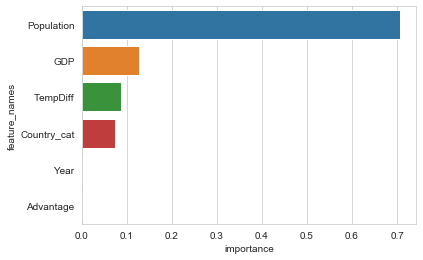

In [196]:
sns.barplot(data = df_importance_top, x = 'importance', y = 'feature_names')

In [197]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(random_state = 42)
model

GradientBoostingRegressor(random_state=42)

In [198]:
model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [199]:
y_test_pred = model.predict(X_test)

In [205]:
del rio['Medal']

In [207]:
rio['Pred_GB'] = pd.DataFrame(y_test_pred.round())
rio.merge(rio_medal, left_on = 'Country', right_on = 'Country', how = 'left')

,Country,City,Year,GDP,Population,TempDiff,Advantage,Country_cat,City_cat,Pred,Pred_GB,Medal
0,China,Rio de Janeiro,2016,1.113795e+13,1.378665e+09,-4.445,0,6,0,91.0,90.0,70
1,Russian Federation,Rio de Janeiro,2016,1.282724e+12,1.443424e+08,3.333,0,24,0,30.0,73.0,56
2,Germany,Rio de Janeiro,2016,3.495163e+12,8.266768e+07,3.889,0,11,0,45.0,45.0,42
3,United States,Rio de Janeiro,2016,1.870719e+13,3.231275e+08,-0.334,0,29,0,104.0,104.0,121
4,Canada,Rio de Janeiro,2016,1.526706e+12,3.628642e+07,-1.667,0,5,0,18.0,20.0,22
5,Cuba,Rio de Janeiro,2016,9.137000e+10,1.147598e+07,-3.900,0,8,0,17.0,20.0,11
6,Australia,Rio de Janeiro,2016,1.210028e+12,2.412716e+07,8.889,0,1,0,42.0,38.0,29
7,Brazil,Rio de Janeiro,2016,1.796275e+12,2.076529e+08,0.000,1,3,0,15.0,23.0,19
8,United Kingdom,Rio de Janeiro,2016,2.659239e+12,6.563724e+07,5.877,0,28,0,68.0,47.0,67
9,Italy,Rio de Janeiro,2016,1.869202e+12,6.060059e+07,-2.223,0,14,0,28.0,32.0,28


In [209]:
y_test = rio_medal['Medal']

In [232]:
y_pred

array([ 10.58409149,  38.38649715,  11.7843918 ,  22.73813763,
         5.80877878,  19.80638091,  89.8065521 ,   7.3230646 ,
        19.62636477,   6.89566619,  38.06509563,  44.87811484,
        13.78828689,  15.64756679,  32.29623945,   8.39343211,
        25.32310849,  27.50059744,  21.38806759,   9.27813407,
         6.75466503,   6.07710072,  13.18038356,  14.18317816,
        72.71997179,  21.94308464,  13.24661204,  19.42808074,
        47.43522563, 103.81644475])

In [231]:
rio_medal = rio_medal.sort_values(by = 'Country').reset_index(drop = True)
y_test = rio_medal.Medal
y_test

0       4
1      29
2       9
3      19
4       3
5      22
6      70
7      10
8      11
9      15
10     42
11     42
12      6
13     15
14     28
15     11
16     41
17     21
18     19
19     18
20      1
21      4
22     11
23      4
24     56
25     17
26     11
27     11
28     67
29    121
Name: Medal, dtype: int64

In [233]:
from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

0.8770609839610726

In [236]:
from sklearn.metrics import mean_squared_error as MSE
np.sqrt(MSE(y_test, y_pred))

8.924394217573468

### 기초분석
#### 국가에 따른 메달수는?

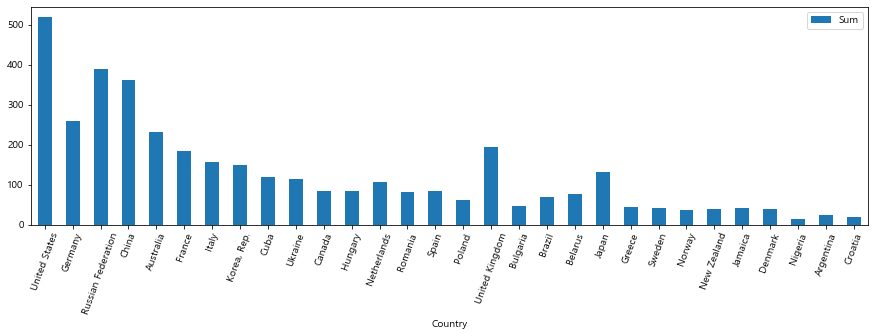

In [118]:
all_medals.plot.bar(x = "Country", y = "Sum", figsize = (15, 4), rot = 70)

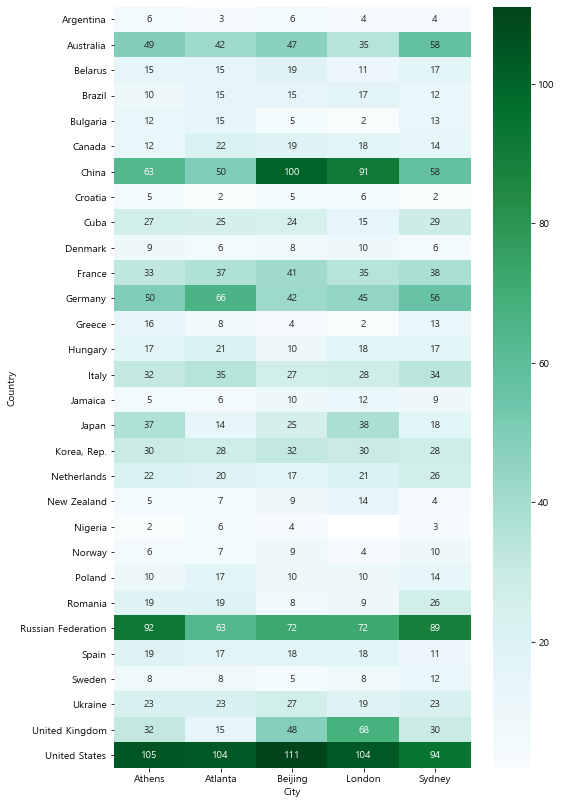

In [119]:
medals_by_country = pd.pivot_table(data = summeroly, index = "Country", columns = ["City"], values = "Medal", aggfunc = "count")
plt.figure(figsize = (8, 14))
sns.heatmap(medals_by_country, cmap = "BuGn", annot = True, fmt = ".0f")

[Text(0, 0.5, 'Count'), Text(0.5, 1.0, 'Beijing')]

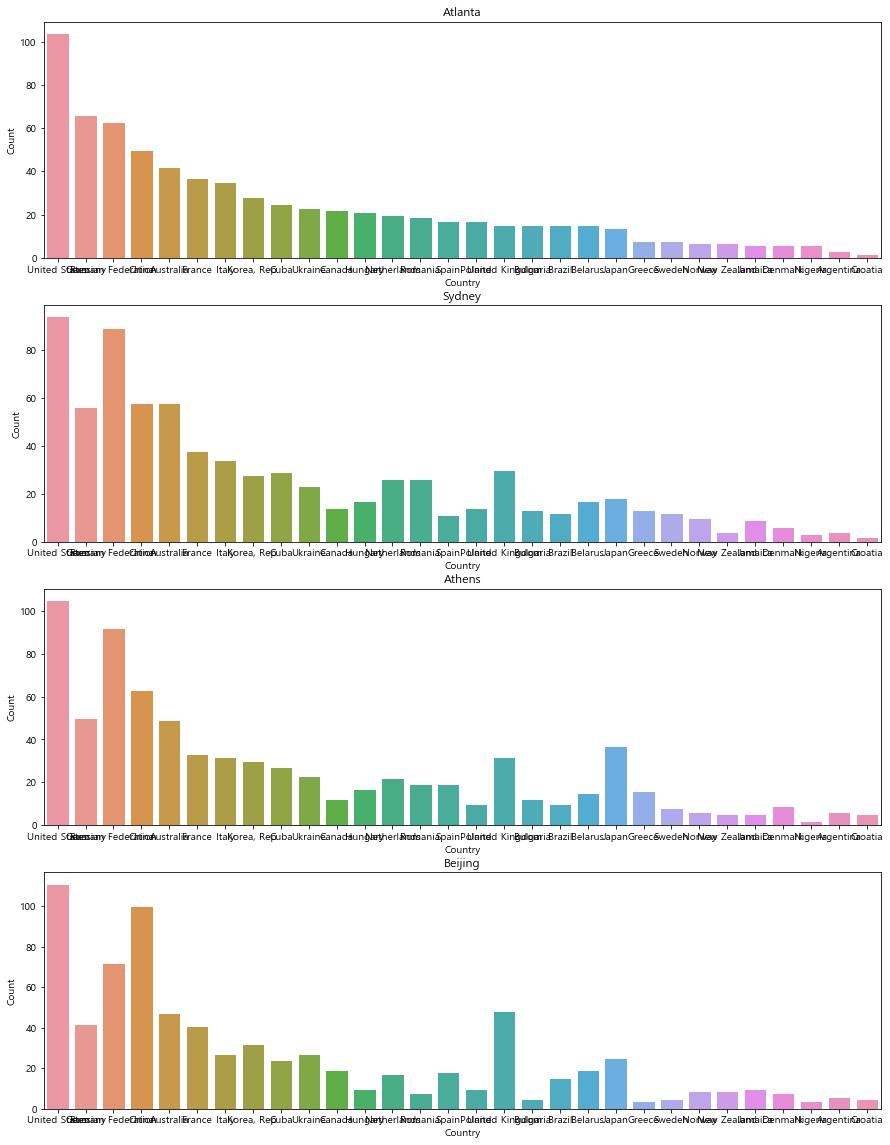

In [120]:
fig, axes = plt.subplots(nrows=4,ncols=1)
fig.set_size_inches(15, 20)
sns.set_style("whitegrid")
# plt.figure(rotation = 30)

sns.barplot(data=all_medals,y="Atlanta", x = "Country", ax=axes[0])
sns.barplot(data=all_medals,y="Sydney",x="Country",orient="v",ax=axes[1])
sns.barplot(data=all_medals,y="Athens",x="Country",orient="v",ax=axes[2])
sns.barplot(data=all_medals,y="Beijing",x="Country",orient="v",ax=axes[3])

axes[0].set(ylabel='Count',title="Atlanta")
axes[1].set(ylabel='Count',title="Sydney")
axes[2].set(ylabel='Count',title="Athens")
axes[3].set(ylabel='Count',title="Beijing")

#### 개최국으로 선정되면 메달수에 영향이 있을까?

#### gdp에 따른 메달수는?

#### 인구수에 따른 메달수는?

#### 개최국과 출신국가의 온도차가 메달수에 영향을 미칠까?

#### 국가별로 메달확보가 쉬운 특정종목이 있을까?

#### 정치체제?!